In [1]:
import requests
import json
import psycopg2
import pandas as pd
import numpy as np
import datetime
from datetime import date
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from collections import Counter
import time
from psycopg2.extras import NamedTupleCursor
from Query_for_data import *

In [2]:
def makeRedshiftConnection():
    red_host = "datawarehouse-cluster.cgatqp75ezrh.ap-southeast-1.redshift.amazonaws.com"
    name = "ram_krishna"
    password = "2tz6zUqx1h4s"
    db_name = "datawarehousedb"
    port = 5439
    con = ''
    
    return red_host, name, password, db_name, port

In [3]:
def getRedshiftData(queryString_input):
    
    red_host, name, password, db_name, port = makeRedshiftConnection()
    
    output = []
    redshiftdata = {}
    list1 = []
    
    try:
        con = psycopg2.connect(host=red_host, user=name, password=password, database="datawarehousedb", port=port)
        query = queryString_input
        cur = con.cursor(cursor_factory=NamedTupleCursor)
        cur.execute(query)
        output = cur.fetchall()
        output = pd.DataFrame(output)
        return output
    
    except psycopg2.Error as e:
        
        print("Error Occurred -> ", e)
        return []

In [4]:
%%time
metadata_query_curr = '''with base as (select bs.businessid 
                         , date(bs.onboarddatenew) as onboarddate
                         , bs.businesstype 
from 
business_snapshot bs 
where date(bs.onboarddatenew) <= '2022-02-04')

select b.businessid, b.onboarddate, b.businesstype, 

max(date(ord.src_created_time)) as max_order_dt,
count(distinct ord.order_id) as total_orders,
count(distinct(date(ord.src_created_time))) as distinct_order_dates


from base b
left join customer_snapshot_ c  on b.businessid = c.businessid
left join(
          select * from  bolt_order_item_snapshot_ bos
          where date(bos.src_created_time) <= '2022-02-04'
          and bos.boltordertype = 'MARKETPLACE'
          ) as ord
          on c.customerid = ord.buyer_id
left join address_snapshot_ ads ON ads.addressentityid = b.businessid
left join listing_snapshot ls on ls.listing_id = ord.listing_id
left join sellerproduct_snapshot sps on sps.sp_id = ls.sp_id
left join product_snapshot_ prod on prod.jpin = sps.jpin
left join category cat on cat.pvid = prod.pvid

where 

b.businessid not in ('BZID-testPuja'
                , 'BZID-tech'
                , 'BZID-sajal'
                , 'BZID-merchCatalog'
                , 'BZID-1304457254'
                , 'BZID-1304463418')
                
AND c.istestcustomer IS FALSE
--and ads.addresstype = 'SHIPPING'


--AND date(ord.src_created_time) <= '2021-01-14'


group by 1,2,3


'''
       

df1 = []
df1 = getRedshiftData(metadata_query_curr)



CPU times: user 575 ms, sys: 308 ms, total: 883 ms
Wall time: 7min 36s


In [7]:
len(pd.unique(df1['businessid']))

137014

In [9]:
i='2022-02-04'


df1['date_ref'] = i
df1['date_ref'] = pd.to_datetime(df1['date_ref'], errors='coerce')

df1['max_order_dt'] = pd.to_datetime(df1['max_order_dt'], errors='coerce')
df1['days_since_last_order'] = df1['date_ref']-df1['max_order_dt']
df1['days_since_last_order'] = df1.days_since_last_order.apply(lambda x: x.days)

df1['onboarddate'] = pd.to_datetime(df1['onboarddate'], errors='coerce')
df1['age_of_biz'] = df1['date_ref']-df1['onboarddate']
df1['age_of_biz'] = df1.age_of_biz.apply(lambda x: x.days)

conditions = [

(df1['days_since_last_order'] >=30) & (df1['days_since_last_order'] <60),
(df1['days_since_last_order'] >=60),
(df1['days_since_last_order'] <30)

]

choices = ['lapsed','churned','actively_ordering']
df1['current_state'] = np.select(conditions, choices)

conditions1 = [
(df1['age_of_biz'] <=60),
(df1['age_of_biz'] >60) & (df1['age_of_biz'] <=90),
(df1['age_of_biz'] >90) & (df1['age_of_biz'] <=120),
(df1['age_of_biz'] >120) & (df1['age_of_biz'] <=150),
(df1['age_of_biz'] >150)

]

choices1 = ['less than equal to 60','b/w 61 to 90','b/w 91 to 120','b/w 121 to 150','greater than 150']
df1['current_business_age'] = np.select(conditions1, choices1)


conditions4 = [
(df1.max_order_dt.notnull()==True),
(df1.max_order_dt.notnull()==False)
]

choices4 = [1,0]
df1['ETB'] = np.select(conditions4, choices4)

conditions5 = [
(df1.prev_max_order_dt.notnull()==True),
(df1.prev_max_order_dt.notnull()==False)
]


final_output = df1





In [10]:
print(final_output['ETB'].value_counts())
#print(final_output['prev_ETB'].value_counts())

1    95068
0    41946
Name: ETB, dtype: int64


In [11]:
final_output.to_excel("predict_output.xlsx",
             sheet_name='raw_data') 

In [12]:
final_output_metadata = final_output[(final_output['ETB']>0)]

In [13]:
final_output_metadata

,businessid,onboarddate,businesstype,max_order_dt,total_orders,distinct_order_dates,date_ref,days_since_last_order,age_of_biz,current_state,current_business_age,ETB
0,BZID-1304419605,2021-07-12,KIRANA_STORE,2022-01-31,119,88,2022-02-04,4.0,207,actively_ordering,greater than 150,1
1,BZID-1304454777,2020-06-08,KIRANA_STORE,2022-02-03,87,74,2022-02-04,1.0,606,actively_ordering,greater than 150,1
2,BZID-1304449908,2020-04-25,KIRANA_STORE,2022-02-03,416,198,2022-02-04,1.0,650,actively_ordering,greater than 150,1
3,BZID-1304458418,2019-05-01,SUPERMARKET,2022-02-02,1019,516,2022-02-04,2.0,1010,actively_ordering,greater than 150,1
4,BZID-1304415437,2021-06-27,SUPERMARKET,2021-11-25,50,30,2022-02-04,71.0,222,churned,greater than 150,1
...,...,...,...,...,...,...,...,...,...,...,...,...
137009,BZID-1304400821,2021-08-11,KIRANA_STORE,2022-01-24,1,1,2022-02-04,11.0,177,actively_ordering,greater than 150,1
137010,BZID-1304353818,2021-11-15,KIRANA_STORE,2022-01-25,1,1,2022-02-04,10.0,81,actively_ordering,b/w 61 to 90,1
137011,BZID-1304358647,2021-10-14,KIRANA_STORE,2021-12-28,3,3,2022-02-04,38.0,113,lapsed,b/w 91 to 120,1
137012,BZID-1304392904,2021-08-26,TEA_STALL,2021-08-26,1,1,2022-02-04,162.0,162,churned,greater than 150,1


In [14]:
len(pd.unique(df1['businessid']))

137014

In [15]:
%%time
metadata_query_master = '''

SELECT DISTINCT final.*
                
FROM            (
                          SELECT    os.*,
                                    --overall_margin_amount        *100.00/gmv_net              AS overall_margin_pct,
                                    total_discount               *100.00/NULLIF(gmv_net,0)    AS pct_discount_taken_on_gmv,
                                    order_items_taken_on_discount*100.00/NULLIF(order_items,0)          AS pct_order_items_taken_on_discount,
                                    sum_return_amount_cust       *100.00/NULLIF(net_of_cancellations,0) AS customer_return_pc,
                                    (total_trips - perfect_delivery)*100.00/NULLIF(total_trips,0)       AS cust_imperfect_delivery_pc,
                                    sum_delivered_amount                                      AS delivered_amount,
                                    sum_reattempt_amount_cust                                 AS reattempt_amount_cust,
                                    sum_return_amount_cust                                    AS return_amount_cust,
                                    sum_return_amount_jt                                      AS return_amount_jt,
                                    sum_missing_amount                                        AS missing_amount,
                                    sum_total_amount                                          AS total_amount,
                                    post_delivery_return_gmv,
                                    total_trips,
                                    perfect_delivery AS perfect_delivery_trips,
                                    complete_rto_trips,
                                    complete_reattempt_trips
                          FROM      (
                                             SELECT   
                                                      businessid,
                                                      addresscity,
                                                      Count(DISTINCT order_date)   AS distinct_orderdates,
                                                      Count(DISTINCT promise_date) AS distinct_promisedates,
                                                      count(DISTINCT( case when cancelled > 0 then order_date end)) cancellationdt_count,
                                                      count(DISTINCT( case when returned > 0 then order_date end)) returndt_count,
                                                      sum(quantity) as quantity_sum,
                                                      sum(cancelled) as cancelled_sum,
                                                      sum(returned) as returned_sum,
                                                      sum(delivered) as delivered_sum,
                                                      Sum(order_item_amount)       AS ordered_gmv,
                                                      Sum(
                                                      CASE
                                                               WHEN product_type = 'FMCG' THEN order_item_amount
                                                               ELSE 0
                                                      END) AS fmcg_gmv,
                                                      Sum(
                                                      CASE
                                                               WHEN product_type = 'Staples' THEN order_item_amount
                                                               ELSE 0
                                                      END)                          AS staples_gmv,
                                                      Sum(tonnage)                  AS tonnage,
                                                      Sum(shipping_charges)         AS total_shipping,
                                                      Count(DISTINCT order_item_id) AS order_items,
                                                      Count(DISTINCT
                                                      CASE
                                                               WHEN bought_on_discount = 1 THEN order_item_id
                                                      END)                 AS order_items_taken_on_discount,
                                                      Sum(discount_amount) AS total_discount,
                                                      Count(DISTINCT
                                                      CASE
                                                               WHEN product_type = 'Staples' THEN category_name
                                                      END) AS staples_category_bought,
                                                      Count(DISTINCT
                                                      CASE
                                                               WHEN product_type = 'FMCG' THEN category_name
                                                      END)                          AS fmcg_category_bought,
                                                      Count(DISTINCT category_name) AS total_categories_bought,
                                                      Count(DISTINCT jpin)          AS total_jpins_bought,
                                                      Count(DISTINCT
                                                      CASE
                                                               WHEN product_type = 'Staples' THEN jpin
                                                      END) AS staples_jpin_bought,
                                                      Count(DISTINCT
                                                      CASE
                                                               WHEN product_type = 'FMCG' THEN jpin
                                                      END) AS fmcg_jpin_bought,
                                                      Sum(
                                                      CASE
                                                               WHEN product_type = 'FMCG' THEN net_gmv
                                                               ELSE 0
                                                      END) AS fmcg_gmv_net,
                                                      Sum(
                                                      CASE
                                                               WHEN product_type = 'Staples' THEN net_gmv
                                                               ELSE 0
                                                      END)                      AS staples_gmv_net,
                                                      Sum(Isnull(net_gmv,0))    AS gmv_net,
                                                      Sum(net_of_cancellations) AS net_of_cancellations
                                                      -- Sum(
--                                                       CASE
--                                                                WHEN product_type = 'Staples' THEN margin
--                                                       END) AS staples_margin,
--                                                       Sum(
--                                                       CASE
--                                                                WHEN product_type = 'FMCG' THEN margin
--                                                       END)        AS fmcg_margin,
--                                                       Sum(margin) AS overall_margin_amount
                                             FROM     (
                                                                SELECT    c.businessid,
                                                                          ad.addresscity,
                                                                          Date(ps.updated_promise_time) AS promise_date,
                                                                          Date(ord.src_created_time)    AS order_date,
                                                                          ord.quantity as quantity,
                                                                          ord.delivered_units as delivered,
                                                                          ord.cancelled_units as cancelled,
                                                                          ord.returned_units as returned,
                                                                          ord.order_item_id,
                                                                          ord.order_item_amount,
                                                                          ord.shipping_charges,
                                                                          ((ord.order_item_amount / NULLIF(ord.quantity,0)) * (ord.quantity - ord.cancelled_units - Isnull(ord.return_requested_quantity,0) - Isnull(ord.returned_units,0))) AS net_gmv,
                                                                          CASE
                                                                                    WHEN cat.DISTRIBUTED IS true THEN 'FMCG'
                                                                                    WHEN cat.DISTRIBUTED IS false THEN 'Staples'
                                                                          END AS product_type,
                                                                          ord.order_item_status,
                                                                          cat.category_name,
                                                                          prod.jpin,
                                                                          (ord.quantity - ord.cancelled_units) * sca.deadweight AS tonnage,
                                                                          CASE
                                                                                    WHEN ord.selling_price - (ord.order_item_amount/NULLIF(quantity,0)) > 0 THEN 1
                                                                                    ELSE 0
                                                                          END AS bought_on_discount,
                                                                          CASE
                                                                                    WHEN ord.selling_price - (ord.order_item_amount/NULLIF(quantity,0)) > 0 THEN ord.selling_price - (ord.order_item_amount/NULLIF(quantity,0))
                                                                                    ELSE 0
                                                                          END                                                                           AS discount_amount,
                                                                          (ord.order_item_amount / NULLIF(ord.quantity,0)) * (ord.quantity - ord.cancelled_units) AS net_of_cancellations
                                                                          --CONVERT( decimal(10,4),(shipping_per_unit*net_order_quantity+total_jw_margin_without_backend+total_backend_margin_jw+
                                                                          --CASE
                                                                          --          WHEN fulfilling_entity='SS' THEN 0
                                                                          --          ELSE total_commission
                                                                          --END+
                                                                          --CASE
                                                                          --          WHEN fulfilling_entity='SS' THEN total_backend_margin_ss+total_ss_margin_without_backend- 0.001*price_per_unit*net_order_quantity
                                                                          --          ELSE 0
                                                                          --END) ) AS margin
                                                                FROM      bolt_order_item_snapshot_ ord
                                                                --JOIN      daily_margin_snapshot mar
                                                                --ON        mar.order_item_id = ord.order_item_id
                                                                LEFT JOIN customer_snapshot_ c
                                                                ON        c.customerid = ord.buyer_id
                                                                AND       c.istestcustomer IS false
                                                                AND       c.businessid NOT LIKE '%ech%'
                                                                AND       c.businessid NOT LIKE '%uja%'
                                                                AND       c.businessid NOT LIKE '%sajal%'
                                                                LEFT JOIN listing_snapshot ls
                                                                ON        ls.listing_id = ord.listing_id
                                                                LEFT JOIN sellerproduct_snapshot sps
                                                                ON        sps.sp_id = ls.sp_id
                                                                LEFT JOIN product_snapshot_ prod
                                                                ON        prod.jpin = sps.jpin
                                                                LEFT JOIN category cat
                                                                ON        cat.pvid = prod.pvid
                                                                LEFT JOIN promise_snapshot ps
                                                                ON        ps.promised_entity_id = ord.order_item_id
                                                                LEFT JOIN supplychainattributes_snapshot_ sca
                                                                ON        sca.jpin = prod.jpin
                                                                LEFT JOIN address_snapshot_ ad
                                                                ON        ad.addressentityid = c.businessid
                                                                AND       ad.addresstype = 'SHIPPING'
                                                                WHERE     date(ord.src_created_time) >= '2021-12-04'
                                                                AND       date(ord.src_created_time) <= '2022-02-04'
                                                                --AND       ord.order_item_amount > 0
                                                                          -- and ord.order_item_status not in ('Cancelled','Ready To Ship', 'Confirmed')
                                                      )
                                             GROUP BY 1,
                                                      2
                                                      ) os
                          LEFT JOIN
                                    (
                                              SELECT    
                                                        c.businessid,
                                                        sum(
                                                        CASE
                                                                  WHEN pem.entity_type = 'DELIVERED' THEN pem.actual_amount
                                                                  ELSE
                                                                            CASE
                                                                                      WHEN di.delta_type = 'WEIGHT_ISSUE' THEN di.amount_difference
                                                                                      ELSE 0
                                                                            END
                                                        END) AS sum_delivered_amount,
                                                        sum(
                                                        CASE
                                                                  WHEN di.delta_type = 'REATTEMPT'
                                                                  AND       di.reason IN ('CUSTOMER_REATTEMPT_EXCEEDED',
                                                                                          'OUTSTANDING_CREDIT_PAYMENT_REJECTED',
                                                                                          'NO_VISIT_ON_CUSTOMER_REQUEST',
                                                                                          'PAYMENT_NOT_AVAILABLE',
                                                                                          'NOT_NEEDED_ANYMORE',
                                                                                          'CHANGED_MY_MIND',
                                                                                          'ALTERNATE_PROCUREMENT',
                                                                                          'SHOP_OWNER_NOT_AVAILABLE',
                                                                                          'PLACED_BY_MISTAKE',
                                                                                          'NO_VISIT_ON_CD_REQUEST',
                                                                                          'DUPLICATE_ORDER',
                                                                                          'SHOP_CLOSED') THEN di.amount_difference
                                                                  ELSE 0
                                                        END) AS sum_reattempt_amount_cust,
                                                        sum(
                                                        CASE
                                                                  WHEN di.delta_type = 'REATTEMPT'
                                                                  AND       di.reason NOT IN ('CUSTOMER_REATTEMPT_EXCEEDED',
                                                                                              'OUTSTANDING_CREDIT_PAYMENT_REJECTED',
                                                                                              'NO_VISIT_ON_CUSTOMER_REQUEST',
                                                                                              'PAYMENT_NOT_AVAILABLE',
                                                                                              'NOT_NEEDED_ANYMORE',
                                                                                              'CHANGED_MY_MIND',
                                                                                              'ALTERNATE_PROCUREMENT',
                                                                                              'SHOP_OWNER_NOT_AVAILABLE',
                                                                                              'PLACED_BY_MISTAKE',
                                                                                              'NO_VISIT_ON_CD_REQUEST',
                                                                                              'DUPLICATE_ORDER',
                                                                                              'SHOP_CLOSED') THEN di.amount_difference
                                                                  ELSE 0
                                                        END) AS sum_reattempt_amount_jt ,
                                                        sum(
                                                        CASE
                                                                  WHEN di.delta_type IN ('RETURN_TO_ORIGIN',
                                                                                         'MRP_ISSUE')
                                                                  AND       di.reason IN ('CUSTOMER_REATTEMPT_EXCEEDED',
                                                                                          'OUTSTANDING_CREDIT_PAYMENT_REJECTED',
                                                                                          'NO_VISIT_ON_CUSTOMER_REQUEST',
                                                                                          'PAYMENT_NOT_AVAILABLE',
                                                                                          'NOT_NEEDED_ANYMORE',
                                                                                          'CHANGED_MY_MIND',
                                                                                          'ALTERNATE_PROCUREMENT',
                                                                                          'SHOP_OWNER_NOT_AVAILABLE',
                                                                                          'PLACED_BY_MISTAKE',
                                                                                          'NO_VISIT_ON_CD_REQUEST',
                                                                                          'DUPLICATE_ORDER',
                                                                                          'SHOP_CLOSED') THEN di.amount_difference
                                                                  ELSE 0
                                                        END) AS sum_return_amount_cust ,
                                                        sum(
                                                        CASE
                                                                  WHEN di.delta_type IN ('RETURN_TO_ORIGIN',
                                                                                         'MRP_ISSUE')
                                                                  AND       di.reason NOT IN ('CUSTOMER_REATTEMPT_EXCEEDED',
                                                                                              'OUTSTANDING_CREDIT_PAYMENT_REJECTED',
                                                                                              'NO_VISIT_ON_CUSTOMER_REQUEST',
                                                                                              'PAYMENT_NOT_AVAILABLE',
                                                                                              'NOT_NEEDED_ANYMORE',
                                                                                              'CHANGED_MY_MIND',
                                                                                              'ALTERNATE_PROCUREMENT',
                                                                                              'SHOP_OWNER_NOT_AVAILABLE',
                                                                                              'PLACED_BY_MISTAKE',
                                                                                              'NO_VISIT_ON_CD_REQUEST',
                                                                                              'DUPLICATE_ORDER',
                                                                                              'SHOP_CLOSED') THEN di.amount_difference
                                                                  ELSE 0
                                                        END) AS sum_return_amount_jt,
                                                        sum(
                                                        CASE
                                                                  WHEN di.delta_type = 'MISSING' THEN di.amount_difference
                                                                  ELSE 0
                                                        END) AS sum_missing_amount ,
                                                        sum(
                                                        CASE
                                                                  WHEN entity_type IN ('RETURN_TO_ORIGIN',
                                                                                       'REATTEMPT') THEN di.amount_difference
                                                                  ELSE pem.expected_amount
                                                        END)                        AS sum_total_amount,
                                                        isnull(post_delivery_gmv,0) AS post_delivery_return_gmv,
                                                        total_trips,
                                                        perfect_delivery,
                                                        complete_rto_trips,
                                                        complete_reattempt_trips
                                              FROM      payment_entity_mapping pem
                                              LEFT JOIN bolt_order_item_v2_snapshot ord
                                              ON        pem.entity_id=ord.order_item_id
                                              LEFT JOIN delta_item di
                                              ON        pem.mapping_id=di.mapping_id
                                              JOIN      customer_snapshot_ c
                                              ON        ord.buyer_id=c.customerid
                                              JOIN
                                                        (
                                                                 SELECT  
                                                                          businessid,
                                                                          count(DISTINCT trip_id) AS total_trips,
                                                                          count(DISTINCT
                                                                          CASE
                                                                                   WHEN order_items = reattempt_order_items
                                                                                   AND      rto_order_items+reattempt_order_items+delivered_items = order_items THEN trip_id
                                                                          END) AS complete_reattempt_trips,
                                                                          count(DISTINCT
                                                                          CASE
                                                                                   WHEN order_items = rto_order_items
                                                                                   AND      rto_order_items+reattempt_order_items+delivered_items = order_items THEN trip_id
                                                                          END) AS complete_rto_trips,
                                                                          count(DISTINCT
                                                                          CASE
                                                                                   WHEN order_items = delivered_items
                                                                                   AND      rto_order_items+reattempt_order_items+delivered_items = order_items THEN trip_id
                                                                          END) AS perfect_delivery
                                                                 FROM     (
                                                                                   SELECT   
                                                                                            businessid,
                                                                                            trip_id,
                                                                                            count(DISTINCT entity_id) AS order_items,
                                                                                            count(DISTINCT
                                                                                            CASE
                                                                                                     WHEN entity_type IN ('RETURN_TO_ORIGIN')
                                                                                                     AND      reason  IN ('CUSTOMER_REATTEMPT_EXCEEDED',
                                                                                                                          'OUTSTANDING_CREDIT_PAYMENT_REJECTED',
                                                                                                                          'NO_VISIT_ON_CUSTOMER_REQUEST',
                                                                                                                          'PAYMENT_NOT_AVAILABLE',
                                                                                                                          'NOT_NEEDED_ANYMORE',
                                                                                                                          'CHANGED_MY_MIND',
                                                                                                                          'ALTERNATE_PROCUREMENT',
                                                                                                                          'SHOP_OWNER_NOT_AVAILABLE',
                                                                                                                          'PLACED_BY_MISTAKE',
                                                                                                                          'NO_VISIT_ON_CD_REQUEST',
                                                                                                                          'DUPLICATE_ORDER',
                                                                                                                          'SHOP_CLOSED') THEN entity_id
                                                                                            END) AS rto_order_items,
                                                                                            count(DISTINCT
                                                                                            CASE
                                                                                                     WHEN entity_type IN ('REATTEMPT')
                                                                                                     AND      reason  IN ('CUSTOMER_REATTEMPT_EXCEEDED',
                                                                                                                          'OUTSTANDING_CREDIT_PAYMENT_REJECTED',
                                                                                                                          'NO_VISIT_ON_CUSTOMER_REQUEST',
                                                                                                                          'PAYMENT_NOT_AVAILABLE',
                                                                                                                          'NOT_NEEDED_ANYMORE',
                                                                                                                          'CHANGED_MY_MIND',
                                                                                                                          'ALTERNATE_PROCUREMENT',
                                                                                                                          'SHOP_OWNER_NOT_AVAILABLE',
                                                                                                                          'PLACED_BY_MISTAKE',
                                                                                                                          'NO_VISIT_ON_CD_REQUEST',
                                                                                                                          'DUPLICATE_ORDER',
                                                                                                                          'SHOP_CLOSED') THEN entity_id
                                                                                            END) AS reattempt_order_items,
                                                                                            count(DISTINCT
                                                                                            CASE
                                                                                                     WHEN entity_type IN ('DELIVERED') THEN entity_id
                                                                                            END) AS delivered_items
                                                                                   FROM    (
                                                                                                      SELECT    
                                                                                                                c.businessid,
                                                                                                                t.trip_id,
                                                                                                                pem.entity_id,
                                                                                                                pem.entity_type,
                                                                                                                di.reason
                                                                                                      FROM      payment_entity_mapping pem
                                                                                                      LEFT JOIN bolt_order_item_v2_snapshot ord
                                                                                                      ON        pem.entity_id=ord.order_item_id
                                                                                                      LEFT JOIN delta_item di
                                                                                                      ON        pem.mapping_id=di.mapping_id
                                                                                                      JOIN      customer_snapshot_ c
                                                                                                      ON        ord.buyer_id=c.customerid
                                                                                                      JOIN      payment py
                                                                                                      ON        pem.payment_id = py.payment_id
                                                                                                      JOIN      dw_shipment.trip_node tn
                                                                                                      ON        tn.node_id = RIGHT( py.trip_node_id, LEN(py.trip_node_id) - 4)
                                                                                                      AND       tn.deleted_at IS NULL
                                                                                                      JOIN      dw_shipment.trip t
                                                                                                      ON        t.trip_id = tn.trip_id
                                                                                                      AND       t.deleted_at IS NULL
                                                                                                      WHERE     trunc(pem.created_time) >= '2021-12-04'
                                                                                                      AND       trunc(pem.created_time) <= '2022-02-04'
                                                                                                      AND       pem.deleted_at IS NULL
                                                                                                      AND       pem.is_deleted IS NULL
                                                                                                      AND       di.deleted_at IS NULL )
                                                                                   GROUP BY 1,
                                                                                            2
                                                                                            )
                                                                 WHERE    order_items > 0
                                                                 GROUP BY 1
                                                                          ) tm
                                              ON        tm.businessid = c.businessid
                                              
                                              LEFT JOIN
                                                        (
                                                                 SELECT   
                                                                          cs.businessid,
                                                                          sum((
                                                                          CASE
                                                                                   WHEN rs.return_state::text <> 'REJECTED'::character VARYING::text
                                                                                   AND      rs.return_state::text <> 'CANCELLED'::character VARYING::text
                                                                                   AND      rs.return_state::text <> 'APPROVED'::character VARYING::text
                                                                                   AND      rs.is_rto IS false THEN rs.return_item_units
                                                                                   ELSE 0
                                                                          END)*((ord.order_item_amount + ord.shipping_charges) / ord.quantity)) AS post_delivery_gmv
                                                                 FROM     return_item_snapshot rs
                                                                 JOIN     bolt_order_item_v2_snapshot ord
                                                                 ON       ord.order_item_id = rs.order_item_id
                                                                 JOIN     customer_snapshot_ cs
                                                                 ON       cs.customerid = ord.buyer_id
                                                                 WHERE    is_rto IS false
                                                                 AND      ord.boltordertype = 'MARKETPLACE'
                                                                 AND      date(rs.src_created_time) >= '2021-12-04'
                                                                 GROUP BY 1
                                                                          ) post
                                              ON        post.businessid = c.businessid
                                              
                                              WHERE     trunc(pem.created_time) >= '2021-12-04'
                                              AND       trunc(pem.created_time) <= '2022-02-04'
                                              AND       pem.deleted_at IS NULL
                                              AND       pem.is_deleted IS NULL
                                              AND       di.deleted_at IS NULL
                                              GROUP BY  1,
                                                        9,
                                                        10,
                                                        11,
                                                        12,
                                                        13
                                                        
                                              ORDER BY  1,
                                                        2) ra
                          ON        os.businessid = ra.businessid
                          
                          WHERE     gmv_net >= 0 
                          ) final
'''
       

df21 = []
df21 = getRedshiftData(metadata_query_master)

#df1 = pd.DataFrame(df1, columns = ['businessid','onboard_date','businestype','businessstatus','max_order_dt','order_dates','netgmv'])

CPU times: user 1.18 s, sys: 591 ms, total: 1.77 s
Wall time: 9min 36s


In [16]:
df21.to_csv('df21.csv')

In [26]:
df21_div = df21[df21['total_amount']!=0]
df21_non_div = df21[df21['total_amount']==0]

In [32]:
df21_div['delivered_amt_pct'] = df21_div['delivered_amount']/df21_div['total_amount']
df21_div['return_amt_cust_pct'] = df21_div['return_amount_cust']/df21_div['total_amount']
df21_div['return_amt_jt_pct'] = df21_div['return_amount_jt']/df21_div['total_amount']
df21_div['missing_amt_pct'] = df21_div['missing_amount']/df21_div['total_amount']
df21_non_div['delivered_amt_pct'] = 0
df21_non_div['return_amt_cust_pct'] = 0
df21_non_div['return_amt_jt_pct'] = 0
df21_non_div['missing_amt_pct'] = 0

/opt/anaconda3/envs/Churn_data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/Churn_data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/Churn_data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [33]:
df21 = pd.concat([df21_div,df21_non_div])

In [34]:
df21.columns

Index(['businessid', 'addresscity', 'distinct_orderdates',
       'distinct_promisedates', 'cancellationdt_count', 'returndt_count',
       'quantity_sum', 'cancelled_sum', 'returned_sum', 'delivered_sum',
       'ordered_gmv', 'fmcg_gmv', 'staples_gmv', 'tonnage', 'total_shipping',
       'order_items', 'order_items_taken_on_discount', 'total_discount',
       'staples_category_bought', 'fmcg_category_bought',
       'total_categories_bought', 'total_jpins_bought', 'staples_jpin_bought',
       'fmcg_jpin_bought', 'fmcg_gmv_net', 'staples_gmv_net', 'gmv_net',
       'net_of_cancellations', 'pct_discount_taken_on_gmv',
       'pct_order_items_taken_on_discount', 'customer_return_pc',
       'cust_imperfect_delivery_pc', 'delivered_amount',
       'reattempt_amount_cust', 'return_amount_cust', 'return_amount_jt',
       'missing_amount', 'total_amount', 'post_delivery_return_gmv',
       'total_trips', 'perfect_delivery_trips', 'complete_rto_trips',
       'complete_reattempt_trips', 'd

In [35]:
df21 = df21.drop(columns=['staples_category_bought', 'fmcg_category_bought'])

In [36]:
df21 = df21.drop(columns=['fmcg_gmv', 'staples_gmv','staples_jpin_bought','fmcg_jpin_bought','fmcg_gmv_net',\
                         'staples_gmv_net','total_shipping','delivered_amount','return_amount_cust','return_amount_jt',
                         'missing_amount','complete_rto_trips'])

In [37]:
df21.columns

Index(['businessid', 'addresscity', 'distinct_orderdates',
       'distinct_promisedates', 'cancellationdt_count', 'returndt_count',
       'quantity_sum', 'cancelled_sum', 'returned_sum', 'delivered_sum',
       'ordered_gmv', 'tonnage', 'order_items',
       'order_items_taken_on_discount', 'total_discount',
       'total_categories_bought', 'total_jpins_bought', 'gmv_net',
       'net_of_cancellations', 'pct_discount_taken_on_gmv',
       'pct_order_items_taken_on_discount', 'customer_return_pc',
       'cust_imperfect_delivery_pc', 'reattempt_amount_cust', 'total_amount',
       'post_delivery_return_gmv', 'total_trips', 'perfect_delivery_trips',
       'complete_reattempt_trips', 'delivered_amt_pct', 'return_amt_cust_pct',
       'return_amt_jt_pct', 'missing_amt_pct'],
      dtype='object')

In [38]:
queryString_app ='''with  cal as (select * from calendar
                  where calendar.calendardate >= '2021-12-04' and calendar.calendardate <= '2022-02-04'
                  )


select  c.businessid,
count ( distinct case when h.en ='ON_APP_CAME_TO_FG' then  cal.calendardate end) cta_dt_cnt,
count ( distinct case when h.en in('ON_LOAD_PRODUCT_LIST_SCREEN','ON_LOAD_PRODUCT_SCREEN')then cal.calendardate end) ppv_plv_dt_cnt,
count ( distinct case when h.en in('ON_TAP_GO_TO_CART','ON_TAP_CART_BOX') then cal.calendardate end) atc_dt_cnt

from (select * from hevo_customer_app_events_webhook he where he.en in ('ON_APP_CAME_TO_FG','ON_LOAD_PRODUCT_LIST_SCREEN',
             'ON_LOAD_PRODUCT_SCREEN',
             'ON_TAP_GO_TO_CART','ON_TAP_CART_BOX')          
      and he.uid is not null) as h

left join customer_snapshot_ c on h.uid = c.customerid  
inner join cal on cast(date(timestamp 'epoch' + (h.ets / 1000) * interval '1 second' + interval '5 hours 30 minutes')as timestamp) = cal.calendardate 
and 
c.istestcustomer is FALSE

and c.businessid is not null
and c.businessid not in ('BZID-testPuja'
                        , 'BZID-tech'
                        , 'BZID-sajal'
                        , 'BZID-merchCatalog'
                        , 'BZID-1304457254'
                        , 'BZID-1304463418')

group by 1

'''
app_data = []
app_data = getRedshiftData(queryString_app)




            

In [16]:
queryString_input40 = '''
        
        select businessid,  count(distinct time_stamp) as total_visits
        
        
        from cs_revisits_data
        where date(time_stamp) >= current_date - 60
        and date(time_stamp) < current_date
        and businessid like 'BZID%'
         group by 1
         
         
         
            
        '''

df40 = []
df40 = getRedshiftData(queryString_input40)



In [17]:
df40.sort_values(by = ['total_visits'])

,businessid,total_visits
16124,BZID-1304413716,1
18954,BZID-1304386098,1
18950,BZID-1304395750,1
18947,BZID-1304409072,1
18946,BZID-1304358647,1
...,...,...
483,BZID-1304356702,10
24605,BZID-1304406466,10
29680,BZID-1304358912,10
1777,BZID-1304390343,11


In [40]:
queryString_input41 = '''
        
        select businessid, count(distinct comm_timestamp) calls
        
        
        from 
        growth_ops_calling_data
        where date(comm_timestamp) >= date('2021-12-04')
        and date(comm_timestamp) <= date('2022-02-04')
    
         group by 1
         
            
        '''

df41 = []
df41 = getRedshiftData(queryString_input41)


In [116]:
queryString_input50 = '''
    select c.businessid, cat.category_name,


count(views)
from (select * from product_oos_views povs where date(ts)>= '2021-10-04'and date(ts)<= '2021-12-04' and oos_state='false') as pov
left join customer_snapshot_ c on pov.customerid = c.customerid
left join address_snapshot_ ad on ad.addressentityid = c.businessid
left join product_snapshot_ ps on
    ps.jpin = pov.jpin
left join productvertical_snapshot_ pvs on ps.pvid = pvs.pvid
 left  join category cat on
    cat.pvid = ps.pvid
where views!= 'load'
 
--and ad.addresscity in ('Vizag','Vizianagaram')
and ad.addresstype = 'SHIPPING'
group by 1,2
'''

df50 = []
df50 = getRedshiftData(queryString_input50)

Error Occurred ->  Query (6738258) cancelled by WLM abort action of Query Monitoring Rule "default_abort".
DETAIL:  
  -----------------------------------------------
  error:  Query (6738258) cancelled by WLM abort action of Query Monitoring Rule "default_abort".
  code:      1078
  context:   Query (6738258) cancelled by WLM abort action of Query Monitoring Rule "default_abort".
  query:     0
  location:  wlm_query_action.cpp:156
  process:   wlm [pid=11779]
  -----------------------------------------------




In [117]:
len(pd.unique(df50['businessid']))

TypeError: list indices must be integers or slices, not str

In [ ]:
df51 = df50

In [ ]:
df51_req = df51[df51['count']>=0]

In [ ]:
df51_cat_count = df51_req.groupby("businessid").agg({"category_name": "nunique"}).reset_index()

In [ ]:
df51_cat_count = df51_cat_count.rename(columns={'category_name':'categories_viewed'})

In [ ]:
df51_cat_count

In [41]:
queryString_input61 = '''

  select 
  
     cut.bz_id,
     cl.status,
     cred.credit_onboard,
     cl.avg_days_past_due,
     cl.current_limit as currentlimit,
     cl.overall_limit as overalllimit,
     cl.total_bounced as totalbounced,
     cl.total_outstanding as totaloutstanding,
     cl.total_outstanding_bounced as totaloutstandingbounced,
     cl.total_credit_ever_used as totalcreditused,
     cl.total_bounced_count as totalbouncedcount,
     cl.total_outstanding_bounced_count as totaloutstandingbouncedcount,
     cl.total_outstanding_count as totaloutstandingcount,
     cl.total_credit_ever_used_count as totalcreditusedcount

    from credit_line cl
    left join credit_product cp on cl.credit_product_id = cp.product_id
    left join credit_user_type cut on cl.credit_user_type_mapping_id = cut.id
    right join   (select 

            cut.bz_id,
            cl.status,
            
            max(date(TIMESTAMP 'epoch' + cl.start_date/1000 *INTERVAL '1 second')) as  credit_onboard
            
        
            from
              credit_line cl
              left join credit_product cp on cl.credit_product_id = cp.product_id
              left join credit_user_type cut on cl.credit_user_type_mapping_id = cut.id
            where
                cp.name not in('DUMMY_PRODUCT')
             -- cp.product_id not in ( '2500541') 
            and cp.name not in ('LoanTap-DPN','DeHaat-BlackSoil','LoanTap-DPN','DUMMY_PRODUCT','JT-Institutional-Sales','JT-BILL2BILL')
            --  and 
            and cut.bz_id like 'BZID%'
            group by
              1,2
            order by 2,1) as cred
    
    on cred.bz_id = cut.bz_id
    and cred.status = cl.status
    and cred.credit_onboard = date(TIMESTAMP 'epoch' + cl.start_date/1000 *INTERVAL '1 second')
    
    

'''

df61 = []
df61 = getRedshiftData(queryString_input61)

In [42]:
df61

,bz_id,status,credit_onboard,avg_days_past_due,currentlimit,overalllimit,totalbounced,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount
0,BZID-1304384397,ACTIVE,2021-10-29,0,13854.99,25000.00,None,11145.01,None,20884.19,0,0,1,5
1,BZID-1304472204,ACTIVE,2016-09-14,0,5289.89,30000.00,0.00,24710.11,0.00,24710.11,0,0,7,7
2,BZID-1304550684,ACTIVE,2022-01-29,0,300.00,300.00,None,0.00,None,None,0,0,0,0
3,BZID-1304471817,ACTIVE,2021-08-18,4,0.00,5000.00,4955.84,5000.00,0.00,22157.76,1,0,1,5
4,BZID-1304473981,ACTIVE,2021-08-18,0,5000.00,5000.00,None,0.00,None,855.20,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81277,BZID-1304453783,BLOCKED,2021-07-24,0,5000.00,5000.00,None,0.00,None,None,0,0,0,0
81278,BZID-1304429392,ACTIVE,2021-07-24,0,1444.84,5000.00,None,3555.16,None,3549.04,0,0,2,2
81279,BZID-1304350880,ACTIVE,2021-12-06,0,5000.00,5000.00,None,0.00,None,None,0,0,0,0
81280,BZID-1304428090,INACTIVE,2021-06-24,0,20000.00,20000.00,4388.00,0.00,0.00,63076.40,1,0,0,8


In [43]:
len(pd.unique(df61['bz_id']))

67120

In [44]:
#df62[df62['bz_id']=='BZID-1304476157']
df61.bz_id.value_counts()

BZID-1304465174    5
BZID-1304472094    5
BZID-1304467442    5
BZID-1304476512    5
BZID-1304466689    4
                  ..
BZID-1304594999    1
BZID-1304400129    1
BZID-1304554550    1
BZID-1304451767    1
BZID-1304384767    1
Name: bz_id, Length: 67120, dtype: int64

In [45]:
df61[df61['bz_id']=='BZID-1304476512']

,bz_id,status,credit_onboard,avg_days_past_due,currentlimit,overalllimit,totalbounced,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount
3247,BZID-1304476512,BLOCKED,2018-12-02,29,148258.10,190000.00,250929.68,41741.90,41741.90,5874529.67,111,2,2,440
38856,BZID-1304476512,ON_HOLD,2020-09-05,26,4323.50,10000.00,250776.46,5676.50,5676.50,6426743.74,158,1,1,477
45268,BZID-1304476512,ACTIVE,2018-12-02,2,3580.74,225000.00,131118.24,221419.26,0.00,4522326.43,11,0,13,356
45269,BZID-1304476512,ACTIVE,2018-12-02,2,214.67,250000.00,49821.34,249785.33,0.00,4925658.99,15,0,14,380
64662,BZID-1304476512,INACTIVE,2017-10-04,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0


In [46]:
df_credit_status = df61[['bz_id', 'status']]

In [47]:
df_credit_status.status.value_counts()

ACTIVE      59482
BLOCKED     11006
INACTIVE     7204
ON_HOLD      3590
Name: status, dtype: int64

In [48]:
conditions7 = [
(df61['status']=='ACTIVE'),
(df61['status']=='BLOCKED'),
(df61['status']=='INACTIVE'),
(df61['status']=='ON_HOLD')
]

choices7 = [4,2,1,3]
df61['status_ind'] = np.select(conditions7, choices7)

In [49]:
df61

,bz_id,status,credit_onboard,avg_days_past_due,currentlimit,overalllimit,totalbounced,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount,status_ind
0,BZID-1304384397,ACTIVE,2021-10-29,0,13854.99,25000.00,None,11145.01,None,20884.19,0,0,1,5,4
1,BZID-1304472204,ACTIVE,2016-09-14,0,5289.89,30000.00,0.00,24710.11,0.00,24710.11,0,0,7,7,4
2,BZID-1304550684,ACTIVE,2022-01-29,0,300.00,300.00,None,0.00,None,None,0,0,0,0,4
3,BZID-1304471817,ACTIVE,2021-08-18,4,0.00,5000.00,4955.84,5000.00,0.00,22157.76,1,0,1,5,4
4,BZID-1304473981,ACTIVE,2021-08-18,0,5000.00,5000.00,None,0.00,None,855.20,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81277,BZID-1304453783,BLOCKED,2021-07-24,0,5000.00,5000.00,None,0.00,None,None,0,0,0,0,2
81278,BZID-1304429392,ACTIVE,2021-07-24,0,1444.84,5000.00,None,3555.16,None,3549.04,0,0,2,2,4
81279,BZID-1304350880,ACTIVE,2021-12-06,0,5000.00,5000.00,None,0.00,None,None,0,0,0,0,4
81280,BZID-1304428090,INACTIVE,2021-06-24,0,20000.00,20000.00,4388.00,0.00,0.00,63076.40,1,0,0,8,1


In [50]:
df_credit_statusind = df_credit_status.groupby(['bz_id']).max('status_ind').reset_index()

In [51]:
df_credit_statusind

,bz_id,status
0,BZID-1304349184,ACTIVE
1,BZID-1304349187,ACTIVE
2,BZID-1304349188,ACTIVE
3,BZID-1304349189,ACTIVE
4,BZID-1304349193,ACTIVE
...,...,...
67115,BZID-tech,ON_HOLD
67116,BZID-testPuja,ACTIVE
67117,BZID-testSaloni,ACTIVE
67118,BZID1304449085,BLOCKED


In [52]:
cred_status = pd.merge(df_credit_statusind,df61,\
                      how='left', left_on=['bz_id','status']\
                             ,right_on=['bz_id','status']).fillna(0)

In [53]:
cred_status

,bz_id,status,credit_onboard,avg_days_past_due,currentlimit,overalllimit,totalbounced,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount,status_ind
0,BZID-1304349184,ACTIVE,2021-12-06,0,5000.00,5000.00,0,0.00,0,0,0,0,0,0,4
1,BZID-1304349187,ACTIVE,2021-12-06,0,5000.00,5000.00,0,0.00,0,0,0,0,0,0,4
2,BZID-1304349188,ACTIVE,2022-02-04,0,300.00,300.00,0,0.00,0,0,0,0,0,0,4
3,BZID-1304349189,ACTIVE,2021-11-29,0,1844.06,21000.00,0,19155.94,0,61073.78,0,0,11,39,4
4,BZID-1304349193,ACTIVE,2021-12-06,0,12000.00,12000.00,0,0.00,0,22029.87,0,0,0,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67203,BZID-tech,ON_HOLD,2021-07-08,75,12860.93,15000.00,2987.32,2139.07,2139.07,138.00,21,10,10,15,3
67204,BZID-testPuja,ACTIVE,2017-07-12,0,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0,4
67205,BZID-testSaloni,ACTIVE,2017-07-12,0,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0,4
67206,BZID1304449085,BLOCKED,2021-02-22,0,5000.00,5000.00,0,0.00,0.00,0,0,0,0,0,2


In [128]:
df_credit_sum = cred_status[['bz_id','status','status_ind','currentlimit', 'overalllimit',\
                      'totalbounced', 'totaloutstanding','totaloutstandingbounced', \
                      'totalcreditused', 'totalbouncedcount',
       'totaloutstandingbouncedcount', 'totaloutstandingcount',
       'totalcreditusedcount']]
       

In [129]:
df_credit_sum = df_credit_sum.fillna(0)

In [130]:
df_credit_sum

,bz_id,status,status_ind,currentlimit,overalllimit,totalbounced,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount
0,BZID-1304349184,ACTIVE,4,5000.00,5000.00,0,0.00,0,0,0,0,0,0
1,BZID-1304349187,ACTIVE,4,5000.00,5000.00,0,0.00,0,0,0,0,0,0
2,BZID-1304349188,ACTIVE,4,300.00,300.00,0,0.00,0,0,0,0,0,0
3,BZID-1304349189,ACTIVE,4,1844.06,21000.00,0,19155.94,0,61073.78,0,0,11,39
4,BZID-1304349193,ACTIVE,4,12000.00,12000.00,0,0.00,0,22029.87,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67203,BZID-tech,ON_HOLD,3,12860.93,15000.00,2987.32,2139.07,2139.07,138.00,21,10,10,15
67204,BZID-testPuja,ACTIVE,4,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0
67205,BZID-testSaloni,ACTIVE,4,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0
67206,BZID1304449085,BLOCKED,2,5000.00,5000.00,0,0.00,0.00,0,0,0,0,0


In [131]:
df_credit_sum_ag = df_credit_sum.groupby(['bz_id','status']).agg({"currentlimit": "sum","overalllimit": "sum",\
                                                         "totalbounced": "sum","totaloutstanding": "sum",\
                                                         "totaloutstandingbounced": "sum","totalcreditused": "sum",\
                                                         "totalbouncedcount": "sum","totaloutstandingbouncedcount": "sum",\
                                                         "totaloutstandingcount": "sum","totalcreditusedcount": "sum",
                                                        
                                                        
                                                        
                                                        
                                                        
                                                        }).reset_index()

In [132]:
df_credit_sum_ag

,bz_id,status,currentlimit,overalllimit,totalbounced,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount
0,BZID-1304349184,ACTIVE,5000.00,5000.00,0,0.00,0,0,0,0,0,0
1,BZID-1304349187,ACTIVE,5000.00,5000.00,0,0.00,0,0,0,0,0,0
2,BZID-1304349188,ACTIVE,300.00,300.00,0,0.00,0,0,0,0,0,0
3,BZID-1304349189,ACTIVE,1844.06,21000.00,0,19155.94,0,61073.78,0,0,11,39
4,BZID-1304349193,ACTIVE,12000.00,12000.00,0,0.00,0,22029.87,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
67115,BZID-tech,ON_HOLD,12860.93,15000.00,2987.32,2139.07,2139.07,138.00,21,10,10,15
67116,BZID-testPuja,ACTIVE,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0
67117,BZID-testSaloni,ACTIVE,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0
67118,BZID1304449085,BLOCKED,5000.00,5000.00,0,0.00,0.00,0,0,0,0,0


In [133]:
df_credit_sum_ag

,bz_id,status,currentlimit,overalllimit,totalbounced,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount
0,BZID-1304349184,ACTIVE,5000.00,5000.00,0,0.00,0,0,0,0,0,0
1,BZID-1304349187,ACTIVE,5000.00,5000.00,0,0.00,0,0,0,0,0,0
2,BZID-1304349188,ACTIVE,300.00,300.00,0,0.00,0,0,0,0,0,0
3,BZID-1304349189,ACTIVE,1844.06,21000.00,0,19155.94,0,61073.78,0,0,11,39
4,BZID-1304349193,ACTIVE,12000.00,12000.00,0,0.00,0,22029.87,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
67115,BZID-tech,ON_HOLD,12860.93,15000.00,2987.32,2139.07,2139.07,138.00,21,10,10,15
67116,BZID-testPuja,ACTIVE,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0
67117,BZID-testSaloni,ACTIVE,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0
67118,BZID1304449085,BLOCKED,5000.00,5000.00,0,0.00,0.00,0,0,0,0,0


In [62]:
credit_utilization_query = '''

  select bz_id, avg(utilization) as avg_daily_utilzation
from (select *,
date(timestamp 'epoch' + (cdt.created_time/1000) * interval '1 second' + interval '5 hours 30 minutes') as created_date,
cdt.created_time,

value,
cla.overall_limit,
(value/NULLIF(cla.overall_limit,0)*100) as utilization

from credit_transaction ct
join credit_transaction_details cdt on cdt.credit_transaction = ct.id
left join (select *,
           max(cl.created_time) over (partition by cl.id, 
                                      date(timestamp 'epoch' + (cl.created_time/1000) * interval '1 second' + interval '5 hours 30 minutes') 
                                      ) as max_ts
           from credit_line_audit cl
           where status = 'ACTIVE' ) cla on ct.credit_line_id = cla.id
left join credit_user_type cut on cla.credit_user_type_mapping_id = cut.id
where transaction_type = 'DEBIT'
and cdt.amount_type = 'BASE'
and date(timestamp 'epoch' + (cdt.created_time/1000) * interval '1 second' + interval '5 hours 30 minutes') >= '2021-12-04'
and date(timestamp 'epoch' + (cdt.created_time/1000) * interval '1 second' + interval '5 hours 30 minutes') <= '2022-02-04'
and max_ts = cla.created_time
)
group by 1
    

'''

cred_utilization = []
cred_utilization = getRedshiftData(credit_utilization_query)

In [134]:
cred_utilization

,bz_id,avg_daily_utilzation
0,BZID-1304375656,87.1124218749999999992
1,BZID-1304413788,66.5062000000000000000
2,BZID-1304456863,137.0456515035854730479
3,BZID-1304428075,33.3065091486291486269
4,BZID-1304418869,37.0373872846936261553
...,...,...
19070,BZID-1304575329,52.8548754208754208737
19071,BZID-1304431750,23.5791793057409879791
19072,BZID-1304561183,33.0868000000000000000
19073,BZID-1304407999,30.9597487931034482724


In [135]:
cred_final = pd.merge(df_credit_sum_ag,cred_utilization,\
                      how='left', left_on=['bz_id']\
                             ,right_on=['bz_id']).fillna(0)

In [136]:
cred_final

,bz_id,status,currentlimit,overalllimit,totalbounced,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount,avg_daily_utilzation
0,BZID-1304349184,ACTIVE,5000.00,5000.00,0,0.00,0,0,0,0,0,0,0
1,BZID-1304349187,ACTIVE,5000.00,5000.00,0,0.00,0,0,0,0,0,0,0
2,BZID-1304349188,ACTIVE,300.00,300.00,0,0.00,0,0,0,0,0,0,0
3,BZID-1304349189,ACTIVE,1844.06,21000.00,0,19155.94,0,61073.78,0,0,11,39,18.8992952206797479593
4,BZID-1304349193,ACTIVE,12000.00,12000.00,0,0.00,0,22029.87,0,0,0,5,64.8657283333333333323
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67115,BZID-tech,ON_HOLD,12860.93,15000.00,2987.32,2139.07,2139.07,138.00,21,10,10,15,0
67116,BZID-testPuja,ACTIVE,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0,0
67117,BZID-testSaloni,ACTIVE,30000.00,30000.00,0.00,0.00,0.00,0.00,0,0,0,0,0
67118,BZID1304449085,BLOCKED,5000.00,5000.00,0,0.00,0.00,0,0,0,0,0,0


In [66]:
ldraw_elig_query = '''
select distinct cs.businessid
FROM hevo_customer_app_events_webhook cae
join customer_snapshot_ cs on cs.customerid = cae.uid
  WHERE en = 'ON_IMPRESSION_BROWSE_SCREEN'
  AND   grpid IN ( 'UINODE-11386038099','UINODE-11386038094','UINODE-11386038141','UINODE-11386038120')
and date(TIMESTAMP 'epoch' +(ets / 1000)*INTERVAL '1 second' + interval '5 hours 30 minutes') >= '2021-10-30'
and enidarr LIKE '%S&W - Cohort%'
'''
ldraw_elig = []
ldraw_elig = getRedshiftData(ldraw_elig_query)

In [67]:
ldraw_elig['elig_ind'] = 1

In [68]:
ldraw_gift_query = '''

select
  distinct cs.businessid
FROM
  hevo_customer_app_events_webhook cae
  join customer_snapshot_ cs on cs.customerid = cae.uid
WHERE
  en = 'ON_CLICK_BROWSE_ITEM'
  AND grpid IN (
    'UINODE-11386038096',
    'UINODE-11386038095',
    'UINODE-11386038138',
    'UINODE-11386038121'
  )
  and date(
    TIMESTAMP 'epoch' + (ets / 1000) * INTERVAL '1 second' + interval '5 hours 30 minutes'
  ) >= '2021-10-30'
  and cardid IN (
    'UINODE-11386038056',
    'UINODE-11386038087',
    'UINODE-11386038130',
    'UINODE-11386038113'
  )

'''
ldraw_gift = []
ldraw_gift = getRedshiftData(ldraw_gift_query)

In [69]:
ldraw_gift['gift_ind'] = 1

In [70]:
ldraw_final = pd.merge(ldraw_elig,ldraw_gift,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [76]:
queryString_input81 = '''
    SELECT   rg.businessid,
         Count(rg.rating) AS rating_cnt,
         ROUND(Avg(rg.rating)) AS avg_rating
FROM     (
                SELECT *
                FROM   (
                                 SELECT    date(timestamp 'epoch' + (ets/1000) * interval '1 second' + interval '5 hours 30 minutes') AS dt,
                                           uid ,
                                           cs.businessid AS businessid,
                                           sid,
                                           seq,
                                           srv_req_ent_id,
                                           srv_id                                                      AS survey_id,
                                           srv_ans_val/1.00                                                 AS rating
                                           --row_number() OVER (partition BY uid, sid ORDER BY seq DESC) AS rnk
                                 FROM      hevo_customer_app_events_webhook
                                 LEFT JOIN customer_snapshot_ cs
                                 ON        cs.customerid = hevo_customer_app_events_webhook.uid
                                 JOIN      address_snapshot_ ads
                                 ON        ads.addressentityid=cs.businessid
                                 AND       addresstype='SHIPPING'
                                 AND       cs.businessid NOT IN ( 'BZID-testPuja' ,
                                                                 'BZID-tech' ,
                                                                 'BZID-sajal' ,
                                                                 'BZID-merchCatalog' ,
                                                                 'BZID-1304457254' ,
                                                                 'BZID-1304463418',
                                                                 'BZID-hubballi',
                                                                 'BZID-1304433825',
                                                                 'BZID-1304436504',
                                                                 'BZID-1304435850' )
                                 WHERE     en = 'ON_SURVEY_RATING_CHANGED'
                                 AND       srv_que_id = 'QES-182'
                                 AND       date(timestamp 'epoch' + (ets/1000) * interval '1 second' + interval '5 hours 30 minutes') >= '2021-12-04'
                                 AND       date(timestamp 'epoch' + (ets/1000) * interval '1 second' + interval '5 hours 30 minutes') <= '2022-02-04' )
        ) rg
JOIN
         (
                   SELECT    date(timestamp 'epoch' + (ets/1000) * interval '1 second' + interval '5 hours 30 minutes') AS dt,
                             uid ,
                             sid,
                             seq,
                             srv_req_ent_id,
                             srv_id      AS survey_id,
                             srv_ans_val AS rating
                   FROM      hevo_customer_app_events_webhook
                   LEFT JOIN customer_snapshot_ cs
                   ON        cs.customerid = hevo_customer_app_events_webhook.uid
                   JOIN      address_snapshot_ ads
                   ON        ads.addressentityid=cs.businessid
                   AND       addresstype='SHIPPING'
                   AND       cs.businessid NOT IN ( 'BZID-testPuja' ,
                                                   'BZID-tech' ,
                                                   'BZID-sajal' ,
                                                   'BZID-merchCatalog' ,
                                                   'BZID-1304457254' ,
                                                   'BZID-1304463418',
                                                   'BZID-hubballi',
                                                   'BZID-1304433825',
                                                   'BZID-1304436504',
                                                   'BZID-1304435850' )
                   WHERE     en = 'ON_SURVEY_SUBMIT'
                   AND       date(timestamp 'epoch' + (ets/1000) * interval '1 second' + interval '5 hours 30 minutes') >= '2021-12-04'
                   AND       date(timestamp 'epoch' + (ets/1000) * interval '1 second' + interval '5 hours 30 minutes') <= '2022-02-04' ) ss
          ON       ss.dt = rg.dt
          AND      ss.uid = rg.uid
          AND      ss.srv_req_ent_id = rg.srv_req_ent_id

--where businessid = 'BZID-1304472890'
group by 1

       

          
'''

df81 = []
df81 = getRedshiftData(queryString_input81)

In [77]:
df81

,businessid,rating_cnt,avg_rating
0,BZID-1304426099,7,5
1,BZID-1304461435,4,5
2,BZID-1304480128,5,4
3,BZID-1304470542,2,1
4,BZID-1304414999,8,5
...,...,...,...
18984,BZID-1304349442,6,2
18985,BZID-1304604364,1,5
18986,BZID-1304589177,1,5
18987,BZID-1304608668,31,3


In [78]:
queryString_input82 = '''
    select 
	customer as businessid, 
	count(distinct target_scheme_id) as target_schemes_count,
    count(distinct( case when milestone_crossed_cv > 0 then milestone_crossed_cv end)) as milestones_achieved_count,
    sum(jc_payout) as total_JC_earned
    
from
(select target_scheme_id, natural_id,description, objective, title, internal_scheme_name,internal_scheme_description, filter_entity_id as Customer,

 sum(case when current_value is not null then current_value else 0 end) as current_value, sum(case when jc_payout > 0 then current_value else 0 end) as milestone_crossed_CV,sum(case when jc_payout is not null then jc_payout else 0 end) as jc_payout, sum(case when burn is not null then burn else 0 end) as burn
 
from
(
select *, 
  case when payout_type = 'ABSOLUTE' then payout_val * 1.00
  	   when payout_type = 'PERCENTAGE' then payout_val * 1.00 * 0.01 * current_value 
  	   end as jc_payout, 
  case when payout_type = 'ABSOLUTE' then payout_val * 1.00 * 0.85 
  	   when payout_type = 'PERCENTAGE' then payout_val * 1.00 * 0.01 * current_value * 0.85 
  	   end as burn
from
(
select ts.target_scheme_id, ts.natural_id, ts.description, ts.objective, ts.title, ts.internal_scheme_name,ts.internal_scheme_description, gir.filter_entity_id, smt.current_value, 
    case when num_ms = 3 then
(
		case when ms1 > current_value then 0
		when ms1 <= current_value and ms2 > current_value then ms1_payout_val
		when ms2 <= current_value and ms3 > current_value then ms2_payout_val
		when ms3 <= current_value then ms3_payout_val end
  )
   when num_ms = 2 then 
(
  case when ms1 > current_value then 0
		when ms1 <= current_value and ms2 > current_value then ms1_payout_val
		when ms2 <= current_value then ms2_payout_val end
  )
when num_ms = 1 then
(
  case when ms1 > current_value then 0
		when ms1 <= current_value then ms1_payout_val end
  ) end
as payout_val,
case when num_ms = 3 then
(
		case when ms1 > current_value then '0'
		when ms1 <= current_value and ms2 > current_value then ms1_payout_mode
		when ms2 <= current_value and ms3 > current_value then ms2_payout_mode
		when ms3 <= current_value then ms3_payout_mode end
  )
   when num_ms = 2 then 
(
  case when ms1 > current_value then '0'
		when ms1 <= current_value and ms2 > current_value then ms1_payout_mode
		when ms2 <= current_value then ms2_payout_mode end
  )
when num_ms = 1 then
(
  case when ms1 > current_value then '0'
		when ms1 <= current_value then ms1_payout_mode end
  ) end
as payout_mode,
case when num_ms = 3 then
(
		case when ms1 > current_value then '0'
		when ms1 <= current_value and ms2 > current_value then ms1_payout_type
		when ms2 <= current_value and ms3 > current_value then ms2_payout_type
		when ms3 <= current_value then ms3_payout_type end
  )
   when num_ms = 2 then 
(
  case when ms1 > current_value then '0'
		when ms1 <= current_value and ms2 > current_value then ms1_payout_type
		when ms2 <= current_value then ms2_payout_type end
  )
when num_ms = 1 then
(
  case when ms1 > current_value then '0'
		when ms1 <= current_value then ms1_payout_type end
  ) end
as payout_type,
		ms.*
		
from dw_target_scheme.target_scheme ts
left join dw_target_scheme.group_inclusion_rules gir on gir.target_scheme_id = ts.target_scheme_id and gir.member_entity_type = 'BUSINESS'
left join dw_target_scheme.scheme_member_target smt on smt.target_scheme_id = ts.target_scheme_id and smt.member_id = gir.filter_entity_id
left join (select m1.target_scheme_id as ts, m1.at_value as ms1, m2.at_value as ms2, m3.at_value as ms3,  m1.value as ms1_payout_val, m1.payout_mode as ms1_payout_mode, m1.payout_type as ms1_payout_type, m2.value as ms2_payout_val, m2.payout_mode as ms2_payout_mode, m2.payout_type as ms2_payout_type, m3.value as ms3_payout_val, m3.payout_mode as ms3_payout_mode, m3.payout_type as ms3_payout_type, num_ms
		   from (select ms.target_scheme_id, ms.at_value, p.value, p.payout_mode, p.payout_type 
                 from dw_target_scheme.milestone ms left join dw_target_scheme.payout p on p.milestone_id = ms.milestone_id) m1
left join (select ms.target_scheme_id, ms.at_value, p.value, p.payout_mode, p.payout_type from dw_target_scheme.milestone ms left join dw_target_scheme.payout p on p.milestone_id = ms.milestone_id) m2 on m2.target_scheme_id = m1.target_scheme_id and m1.at_value < m2.at_value
left join (select ms.target_scheme_id, ms.at_value, p.value, p.payout_mode, p.payout_type from dw_target_scheme.milestone ms left join dw_target_scheme.payout p on p.milestone_id = ms.milestone_id) m3 on m3.target_scheme_id = m1.target_scheme_id and m2.at_value < m3.at_value
left join 
(
select target_scheme_id as ts, count(distinct milestone_id) as num_ms
from dw_target_scheme.milestone
group by 1
) a on a.ts = m1.target_scheme_id
where case when a.num_ms = 1 then m1.at_value is not null and m2.at_value is null and m3.at_value is null
			when a.num_ms = 2 then m1.at_value is not null and m2.at_value is not null and m3.at_value is null
			when a.num_ms = 3 then m1.at_value is not null and m2.at_value is not null and m3.at_value is not null
			else false end) ms on ms.ts = ts.target_scheme_id
where ts.target_scheme_status = 'ACTIVE' 
--   and date_add(date_add(from_unixtime(ts.end_time/1000), interval '5 hours'),interval '30 minutes') >= '2022-01-01'
  and date(timestamp 'epoch' + (ts.end_time/1000) * interval '1 second' + interval '5 hours 30 minutes') >= '2021-12-04'
  and date(timestamp 'epoch' + (ts.end_time/1000) * interval '1 second' + interval '5 hours 30 minutes') <= '2022-02-04'
  
 --  ##and ts.target_scheme_id in (100003202, 100003203)
) a
  ) a
group by 1,2,3,4,5,6,7,8) o
where current_value > 0
group by 1
 

'''

df82 = []
df82 = getRedshiftData(queryString_input82)

In [79]:
df82.target_schemes_count.min()

1

In [80]:
queryString_input83 = '''
    select business_id, sum(points_redeemed) as sc_points_red, count(distinct reward_id) as sc_rewards_count
from dw_superclub.redeemed_rewards
where current_status not in ('CANCELLED','Cancelled','cancelled')
and date(rs_last_updated_time) >= '2021-12-04'
and date(rs_last_updated_time) <= '2022-02-04'
group by 1

'''

df83 = []
df83 = getRedshiftData(queryString_input83)

In [81]:
df83 = df83.rename(columns={"business_id": "businessid"})

In [82]:
null_search_query1 = '''

WITH base AS
(
       SELECT *
              --   dt
              --   , en_plus_1
              --   , count(*) as occ
       FROM   (
                       SELECT   * ,
                                Lag(en, 1) OVER(partition BY sid ORDER BY seq) AS en_plus_1 ,
                                Lag(en, 2) OVER(partition BY sid ORDER BY seq) AS en_plus_2
                       FROM     (
                                          SELECT
                                                    --ets
                                                    cs.businessid ,
                                                    uid ,
                                                    en ,
                                                    sid ,
                                                    seq ,
                                                    eid ,
                                                    calendar.month
                                          FROM      hevo_customer_app_events_webhook
                                          LEFT JOIN customer_snapshot_ cs
                                          ON        cs.customerid = hevo_customer_app_events_webhook.uid
                                          JOIN      address_snapshot_ ads
                                          ON        ads.addressentityid = cs.businessid
                                          AND       addresstype = 'SHIPPING'
                                          AND       cs.businessid NOT IN ( 'BZID-testPuja' ,
                                                                          'BZID-tech' ,
                                                                          'BZID-sajal' ,
                                                                          'BZID-merchCatalog' ,
                                                                          'BZID-1304457254' ,
                                                                          'BZID-1304463418' ,
                                                                          'BZID-hubballi' ,
                                                                          'BZID-1304433825' ,
                                                                          'BZID-1304436504' ,
                                                                          'BZID-1304435850' )
                                          LEFT JOIN calendar
                                          ON        date(timestamp 'epoch' + (ets / 1000) * interval '1 second' + interval '5 hours 30 minutes') = calendar.calendardate
                                          WHERE
                                                    --           etype = 'UA'
                                                    cat IN ( 'SEARCH' ,
                                                            'PRODUCT' )
                                          AND       calendar.calendardate <= '2022-02-04'
                                          AND       calendar.calendardate >= '2021-12-04'
                                                    --and ets < extract('epoch' from current_date + 1 )::BIGINT * 1000
                                                    --and  ads.addresscity in ('Bengaluru','Bangalore','Chikkaballapura','Tumkur','Hosur',
                                                    --'Mysore','Mandya','Hassan','Hubballi','Belgaum','Dharwad','Davanagere','Haveri',
                                                    --'Pune','Hyderabad')
                                          AND       appvc IN
                                                              (
                                                              SELECT DISTINCT appvc
                                                              FROM            hevo_customer_app_events_webhook) ) )
       WHERE  en IN ( 'ON_ERROR_EMPTY_PRODUCT_LIST_SCREEN' )
       AND    (
                     en_plus_1 NOT IN ( 'ON_LOAD_PRODUCT_LIST_SCREEN' ,
                                       'ON_ERROR_EMPTY_PRODUCT_LIST_SCREEN' )
              OR     (
                            en_plus_2 = 'ON_SUBMIT_SEARCH_QUERY' ) )
       AND    en_plus_1 IS NOT NULL )
SELECT   businessid ,
         count(*) AS null_search_cnt
FROM     base
GROUP BY 1
ORDER BY 1



'''


In [83]:
null_search1 = getRedshiftData(null_search_query1)
#null_search2 = getRedshiftData(null_search_query2)

In [84]:
null_search1

,businessid,null_search_cnt
0,BZID-1304349184,3
1,BZID-1304349187,6
2,BZID-1304349189,15
3,BZID-1304349194,1
4,BZID-1304349197,5
...,...,...
22436,BZID-1304611321,1
22437,BZID-1304611323,3
22438,BZID-1404573275,2
22439,BZID-merchCatalogHyd,11


In [87]:
final_output_metadata.head()

,businessid,onboarddate,businesstype,max_order_dt,total_orders,distinct_order_dates,date_ref,days_since_last_order,age_of_biz,current_state,current_business_age,ETB
0,BZID-1304419605,2021-07-12,KIRANA_STORE,2022-01-31,119,88,2022-02-04,4.0,207,actively_ordering,greater than 150,1
1,BZID-1304454777,2020-06-08,KIRANA_STORE,2022-02-03,87,74,2022-02-04,1.0,606,actively_ordering,greater than 150,1
2,BZID-1304449908,2020-04-25,KIRANA_STORE,2022-02-03,416,198,2022-02-04,1.0,650,actively_ordering,greater than 150,1
3,BZID-1304458418,2019-05-01,SUPERMARKET,2022-02-02,1019,516,2022-02-04,2.0,1010,actively_ordering,greater than 150,1
4,BZID-1304415437,2021-06-27,SUPERMARKET,2021-11-25,50,30,2022-02-04,71.0,222,churned,greater than 150,1


In [88]:
output_metadata = final_output_metadata[['businessid', 'businesstype','age_of_biz',
                                        'current_business_age','current_state']]

In [89]:
# conditions79 = [
# (output_metadata['current_state']=='actively_ordeing'),
# (output_metadata['current_state']=='lapsed'),
# (output_metadata['current_state']=='churned')

# ]

# choices79 = [0,0,1]
# output_metadata['churn_ind'] = np.select(conditions79, choices79)

In [90]:
output_metadata

,businessid,businesstype,age_of_biz,current_business_age,current_state
0,BZID-1304419605,KIRANA_STORE,207,greater than 150,actively_ordering
1,BZID-1304454777,KIRANA_STORE,606,greater than 150,actively_ordering
2,BZID-1304449908,KIRANA_STORE,650,greater than 150,actively_ordering
3,BZID-1304458418,SUPERMARKET,1010,greater than 150,actively_ordering
4,BZID-1304415437,SUPERMARKET,222,greater than 150,churned
...,...,...,...,...,...
137009,BZID-1304400821,KIRANA_STORE,177,greater than 150,actively_ordering
137010,BZID-1304353818,KIRANA_STORE,81,b/w 61 to 90,actively_ordering
137011,BZID-1304358647,KIRANA_STORE,113,b/w 91 to 120,lapsed
137012,BZID-1304392904,TEA_STALL,162,greater than 150,churned


In [127]:
#output_metadata=output_metadata.rename(columns={"current_state": "future_state", "prev_state": "current_state"})

In [91]:
output_metadata

,businessid,businesstype,age_of_biz,current_business_age,current_state
0,BZID-1304419605,KIRANA_STORE,207,greater than 150,actively_ordering
1,BZID-1304454777,KIRANA_STORE,606,greater than 150,actively_ordering
2,BZID-1304449908,KIRANA_STORE,650,greater than 150,actively_ordering
3,BZID-1304458418,SUPERMARKET,1010,greater than 150,actively_ordering
4,BZID-1304415437,SUPERMARKET,222,greater than 150,churned
...,...,...,...,...,...
137009,BZID-1304400821,KIRANA_STORE,177,greater than 150,actively_ordering
137010,BZID-1304353818,KIRANA_STORE,81,b/w 61 to 90,actively_ordering
137011,BZID-1304358647,KIRANA_STORE,113,b/w 91 to 120,lapsed
137012,BZID-1304392904,TEA_STALL,162,greater than 150,churned


In [92]:
app_data

,businessid,cta_dt_cnt,ppv_plv_dt_cnt,atc_dt_cnt
0,BZID-1304462321,51,37,30
1,BZID-1304465551,43,32,25
2,BZID-1304598536,7,5,1
3,BZID-1304448580,34,31,15
4,BZID-1304385406,60,60,57
...,...,...,...,...
78679,BZID-1304433241,1,0,0
78680,BZID-1304378683,1,0,0
78681,BZID-1304376957,1,0,0
78682,BZID-1304406077,2,0,0


In [93]:
meta_app = pd.merge(output_metadata,app_data,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [94]:
meta_app

,businessid,businesstype,age_of_biz,current_business_age,current_state,cta_dt_cnt,ppv_plv_dt_cnt,atc_dt_cnt
0,BZID-1304419605,KIRANA_STORE,207,greater than 150,actively_ordering,55.0,49.0,38.0
1,BZID-1304454777,KIRANA_STORE,606,greater than 150,actively_ordering,56.0,34.0,31.0
2,BZID-1304449908,KIRANA_STORE,650,greater than 150,actively_ordering,57.0,51.0,28.0
3,BZID-1304458418,SUPERMARKET,1010,greater than 150,actively_ordering,59.0,44.0,25.0
4,BZID-1304415437,SUPERMARKET,222,greater than 150,churned,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...
95063,BZID-1304400821,KIRANA_STORE,177,greater than 150,actively_ordering,2.0,1.0,0.0
95064,BZID-1304353818,KIRANA_STORE,81,b/w 61 to 90,actively_ordering,2.0,0.0,0.0
95065,BZID-1304358647,KIRANA_STORE,113,b/w 91 to 120,lapsed,15.0,15.0,5.0
95066,BZID-1304392904,TEA_STALL,162,greater than 150,churned,0.0,0.0,0.0


In [95]:
mega_data = df21


In [96]:
mega_meta_app = pd.merge(meta_app,mega_data,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [97]:
mega_meta_app

,businessid,businesstype,age_of_biz,current_business_age,current_state,cta_dt_cnt,ppv_plv_dt_cnt,atc_dt_cnt,addresscity,distinct_orderdates,...,reattempt_amount_cust,total_amount,post_delivery_return_gmv,total_trips,perfect_delivery_trips,complete_reattempt_trips,delivered_amt_pct,return_amt_cust_pct,return_amt_jt_pct,missing_amt_pct
0,BZID-1304419605,KIRANA_STORE,207,greater than 150,actively_ordering,55.0,49.0,38.0,Coimbatore,33.0,...,0.00,41690.96,75.648,34.0,33.0,0.0,0.9770763254192275735555141930,0.02171717801652924279028355308,0.001206496564243183654202253918,0
1,BZID-1304454777,KIRANA_STORE,606,greater than 150,actively_ordering,56.0,34.0,31.0,Bengaluru,17.0,...,2766.20,46307.54,0.000,21.0,16.0,1.0,0.8866527999543918765712883906,0.004898554317504233651798389636,0,0.01683073642003008581323905351
2,BZID-1304449908,KIRANA_STORE,650,greater than 150,actively_ordering,57.0,51.0,28.0,Bengaluru,28.0,...,0.00,145125.24,0.000,32.0,31.0,0.0,0.9988740759360673580970477637,0,0.001125924063932641902952236289,0
3,BZID-1304458418,SUPERMARKET,1010,greater than 150,actively_ordering,59.0,44.0,25.0,Bengaluru,21.0,...,0.00,226250.87,0.000,23.0,21.0,0.0,0.9840225144769609062718742253,0.009672537391789918863074427073,0.005057085526345158363368945277,0.001247862604904016501682402370
4,BZID-1304415437,SUPERMARKET,222,greater than 150,churned,3.0,2.0,0.0,0,0.0,...,0,0,0.000,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95063,BZID-1304400821,KIRANA_STORE,177,greater than 150,actively_ordering,2.0,1.0,0.0,Guntur,1.0,...,0.00,471.00,0.000,1.0,1.0,0.0,1,0,0,0
95064,BZID-1304353818,KIRANA_STORE,81,b/w 61 to 90,actively_ordering,2.0,0.0,0.0,Salem,1.0,...,0.00,471.12,0.000,1.0,1.0,0.0,1,0,0,0
95065,BZID-1304358647,KIRANA_STORE,113,b/w 91 to 120,lapsed,15.0,15.0,5.0,Chennai,3.0,...,0.00,2707.87,0.000,3.0,3.0,0.0,1,0,0,0
95066,BZID-1304392904,TEA_STALL,162,greater than 150,churned,0.0,0.0,0.0,0,0.0,...,0,0,0.000,0.0,0.0,0.0,0,0,0,0


In [98]:
mega_meta_app.columns

Index(['businessid', 'businesstype', 'age_of_biz', 'current_business_age',
       'current_state', 'cta_dt_cnt', 'ppv_plv_dt_cnt', 'atc_dt_cnt',
       'addresscity', 'distinct_orderdates', 'distinct_promisedates',
       'cancellationdt_count', 'returndt_count', 'quantity_sum',
       'cancelled_sum', 'returned_sum', 'delivered_sum', 'ordered_gmv',
       'tonnage', 'order_items', 'order_items_taken_on_discount',
       'total_discount', 'total_categories_bought', 'total_jpins_bought',
       'gmv_net', 'net_of_cancellations', 'pct_discount_taken_on_gmv',
       'pct_order_items_taken_on_discount', 'customer_return_pc',
       'cust_imperfect_delivery_pc', 'reattempt_amount_cust', 'total_amount',
       'post_delivery_return_gmv', 'total_trips', 'perfect_delivery_trips',
       'complete_reattempt_trips', 'delivered_amt_pct', 'return_amt_cust_pct',
       'return_amt_jt_pct', 'missing_amt_pct'],
      dtype='object')

In [99]:
mega_meta_app = mega_meta_app.drop(['businesstype','age_of_biz','current_business_age','addresscity','tonnage','order_items_taken_on_discount',
                                    'ordered_gmv'], axis=1)







In [100]:
mega_meta_app

,businessid,current_state,cta_dt_cnt,ppv_plv_dt_cnt,atc_dt_cnt,distinct_orderdates,distinct_promisedates,cancellationdt_count,returndt_count,quantity_sum,...,reattempt_amount_cust,total_amount,post_delivery_return_gmv,total_trips,perfect_delivery_trips,complete_reattempt_trips,delivered_amt_pct,return_amt_cust_pct,return_amt_jt_pct,missing_amt_pct
0,BZID-1304419605,actively_ordering,55.0,49.0,38.0,33.0,32.0,0.0,2.0,2165.0,...,0.00,41690.96,75.648,34.0,33.0,0.0,0.9770763254192275735555141930,0.02171717801652924279028355308,0.001206496564243183654202253918,0
1,BZID-1304454777,actively_ordering,56.0,34.0,31.0,17.0,20.0,2.0,6.0,3927.0,...,2766.20,46307.54,0.000,21.0,16.0,1.0,0.8866527999543918765712883906,0.004898554317504233651798389636,0,0.01683073642003008581323905351
2,BZID-1304449908,actively_ordering,57.0,51.0,28.0,28.0,34.0,6.0,4.0,6777.0,...,0.00,145125.24,0.000,32.0,31.0,0.0,0.9988740759360673580970477637,0,0.001125924063932641902952236289,0
3,BZID-1304458418,actively_ordering,59.0,44.0,25.0,21.0,25.0,5.0,6.0,6259.0,...,0.00,226250.87,0.000,23.0,21.0,0.0,0.9840225144769609062718742253,0.009672537391789918863074427073,0.005057085526345158363368945277,0.001247862604904016501682402370
4,BZID-1304415437,churned,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.000,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95063,BZID-1304400821,actively_ordering,2.0,1.0,0.0,1.0,1.0,0.0,0.0,60.0,...,0.00,471.00,0.000,1.0,1.0,0.0,1,0,0,0
95064,BZID-1304353818,actively_ordering,2.0,0.0,0.0,1.0,1.0,0.0,0.0,60.0,...,0.00,471.12,0.000,1.0,1.0,0.0,1,0,0,0
95065,BZID-1304358647,lapsed,15.0,15.0,5.0,3.0,3.0,0.0,0.0,168.0,...,0.00,2707.87,0.000,3.0,3.0,0.0,1,0,0,0
95066,BZID-1304392904,churned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.000,0.0,0.0,0.0,0,0,0,0


In [101]:
mega_meta_app_orders = mega_meta_app

In [102]:
mega_meta_app_orders

,businessid,current_state,cta_dt_cnt,ppv_plv_dt_cnt,atc_dt_cnt,distinct_orderdates,distinct_promisedates,cancellationdt_count,returndt_count,quantity_sum,...,reattempt_amount_cust,total_amount,post_delivery_return_gmv,total_trips,perfect_delivery_trips,complete_reattempt_trips,delivered_amt_pct,return_amt_cust_pct,return_amt_jt_pct,missing_amt_pct
0,BZID-1304419605,actively_ordering,55.0,49.0,38.0,33.0,32.0,0.0,2.0,2165.0,...,0.00,41690.96,75.648,34.0,33.0,0.0,0.9770763254192275735555141930,0.02171717801652924279028355308,0.001206496564243183654202253918,0
1,BZID-1304454777,actively_ordering,56.0,34.0,31.0,17.0,20.0,2.0,6.0,3927.0,...,2766.20,46307.54,0.000,21.0,16.0,1.0,0.8866527999543918765712883906,0.004898554317504233651798389636,0,0.01683073642003008581323905351
2,BZID-1304449908,actively_ordering,57.0,51.0,28.0,28.0,34.0,6.0,4.0,6777.0,...,0.00,145125.24,0.000,32.0,31.0,0.0,0.9988740759360673580970477637,0,0.001125924063932641902952236289,0
3,BZID-1304458418,actively_ordering,59.0,44.0,25.0,21.0,25.0,5.0,6.0,6259.0,...,0.00,226250.87,0.000,23.0,21.0,0.0,0.9840225144769609062718742253,0.009672537391789918863074427073,0.005057085526345158363368945277,0.001247862604904016501682402370
4,BZID-1304415437,churned,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.000,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95063,BZID-1304400821,actively_ordering,2.0,1.0,0.0,1.0,1.0,0.0,0.0,60.0,...,0.00,471.00,0.000,1.0,1.0,0.0,1,0,0,0
95064,BZID-1304353818,actively_ordering,2.0,0.0,0.0,1.0,1.0,0.0,0.0,60.0,...,0.00,471.12,0.000,1.0,1.0,0.0,1,0,0,0
95065,BZID-1304358647,lapsed,15.0,15.0,5.0,3.0,3.0,0.0,0.0,168.0,...,0.00,2707.87,0.000,3.0,3.0,0.0,1,0,0,0
95066,BZID-1304392904,churned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.000,0.0,0.0,0.0,0,0,0,0


In [103]:
df_dsat = df81

In [104]:
mega_meta_app_orders_dsat = pd.merge(mega_meta_app_orders,df_dsat,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid'])

In [105]:
mega_meta_app_orders_dsat.head()

,businessid,current_state,cta_dt_cnt,ppv_plv_dt_cnt,atc_dt_cnt,distinct_orderdates,distinct_promisedates,cancellationdt_count,returndt_count,quantity_sum,...,post_delivery_return_gmv,total_trips,perfect_delivery_trips,complete_reattempt_trips,delivered_amt_pct,return_amt_cust_pct,return_amt_jt_pct,missing_amt_pct,rating_cnt,avg_rating
0,BZID-1304419605,actively_ordering,55.0,49.0,38.0,33.0,32.0,0.0,2.0,2165.0,...,75.648,34.0,33.0,0.0,0.9770763254192275735555141930,0.02171717801652924279028355308,0.001206496564243183654202253918,0,1.0,1
1,BZID-1304454777,actively_ordering,56.0,34.0,31.0,17.0,20.0,2.0,6.0,3927.0,...,0.000,21.0,16.0,1.0,0.8866527999543918765712883906,0.004898554317504233651798389636,0,0.01683073642003008581323905351,20.0,5
2,BZID-1304449908,actively_ordering,57.0,51.0,28.0,28.0,34.0,6.0,4.0,6777.0,...,0.000,32.0,31.0,0.0,0.9988740759360673580970477637,0,0.001125924063932641902952236289,0,1.0,1
3,BZID-1304458418,actively_ordering,59.0,44.0,25.0,21.0,25.0,5.0,6.0,6259.0,...,0.000,23.0,21.0,0.0,0.9840225144769609062718742253,0.009672537391789918863074427073,0.005057085526345158363368945277,0.001247862604904016501682402370,19.0,4
4,BZID-1304415437,churned,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0,0,0,0,NaN,NaN


In [106]:
mega_meta_app_orders_dsat['dsat_ind'] = np.where(mega_meta_app_orders_dsat['avg_rating'].isnull(),0,1)

In [107]:
mega_meta_app_orders_dsat.fillna(0)

,businessid,current_state,cta_dt_cnt,ppv_plv_dt_cnt,atc_dt_cnt,distinct_orderdates,distinct_promisedates,cancellationdt_count,returndt_count,quantity_sum,...,total_trips,perfect_delivery_trips,complete_reattempt_trips,delivered_amt_pct,return_amt_cust_pct,return_amt_jt_pct,missing_amt_pct,rating_cnt,avg_rating,dsat_ind
0,BZID-1304419605,actively_ordering,55.0,49.0,38.0,33.0,32.0,0.0,2.0,2165.0,...,34.0,33.0,0.0,0.9770763254192275735555141930,0.02171717801652924279028355308,0.001206496564243183654202253918,0,1.0,1,1
1,BZID-1304454777,actively_ordering,56.0,34.0,31.0,17.0,20.0,2.0,6.0,3927.0,...,21.0,16.0,1.0,0.8866527999543918765712883906,0.004898554317504233651798389636,0,0.01683073642003008581323905351,20.0,5,1
2,BZID-1304449908,actively_ordering,57.0,51.0,28.0,28.0,34.0,6.0,4.0,6777.0,...,32.0,31.0,0.0,0.9988740759360673580970477637,0,0.001125924063932641902952236289,0,1.0,1,1
3,BZID-1304458418,actively_ordering,59.0,44.0,25.0,21.0,25.0,5.0,6.0,6259.0,...,23.0,21.0,0.0,0.9840225144769609062718742253,0.009672537391789918863074427073,0.005057085526345158363368945277,0.001247862604904016501682402370,19.0,4,1
4,BZID-1304415437,churned,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95063,BZID-1304400821,actively_ordering,2.0,1.0,0.0,1.0,1.0,0.0,0.0,60.0,...,1.0,1.0,0.0,1,0,0,0,0.0,0,0
95064,BZID-1304353818,actively_ordering,2.0,0.0,0.0,1.0,1.0,0.0,0.0,60.0,...,1.0,1.0,0.0,1,0,0,0,0.0,0,0
95065,BZID-1304358647,lapsed,15.0,15.0,5.0,3.0,3.0,0.0,0.0,168.0,...,3.0,3.0,0.0,1,0,0,0,0.0,0,0
95066,BZID-1304392904,churned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0.0,0,0


In [108]:
calls_data = df41

In [109]:
revisits_data = df40

In [110]:
mega_meta_app_orders_dsat_call = pd.merge(mega_meta_app_orders_dsat,calls_data,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [111]:
mega_meta_app_orders_dsat_call_visits = pd.merge(mega_meta_app_orders_dsat_call,revisits_data,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [112]:
mega_meta_app_orders_dsat_call_visits

,businessid,current_state,cta_dt_cnt,ppv_plv_dt_cnt,atc_dt_cnt,distinct_orderdates,distinct_promisedates,cancellationdt_count,returndt_count,quantity_sum,...,complete_reattempt_trips,delivered_amt_pct,return_amt_cust_pct,return_amt_jt_pct,missing_amt_pct,rating_cnt,avg_rating,dsat_ind,calls,total_visits
0,BZID-1304419605,actively_ordering,55.0,49.0,38.0,33.0,32.0,0.0,2.0,2165.0,...,0.0,0.9770763254192275735555141930,0.02171717801652924279028355308,0.001206496564243183654202253918,0,1.0,1,1,8.0,1.0
1,BZID-1304454777,actively_ordering,56.0,34.0,31.0,17.0,20.0,2.0,6.0,3927.0,...,1.0,0.8866527999543918765712883906,0.004898554317504233651798389636,0,0.01683073642003008581323905351,20.0,5,1,1.0,0.0
2,BZID-1304449908,actively_ordering,57.0,51.0,28.0,28.0,34.0,6.0,4.0,6777.0,...,0.0,0.9988740759360673580970477637,0,0.001125924063932641902952236289,0,1.0,1,1,2.0,0.0
3,BZID-1304458418,actively_ordering,59.0,44.0,25.0,21.0,25.0,5.0,6.0,6259.0,...,0.0,0.9840225144769609062718742253,0.009672537391789918863074427073,0.005057085526345158363368945277,0.001247862604904016501682402370,19.0,4,1,1.0,0.0
4,BZID-1304415437,churned,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95063,BZID-1304400821,actively_ordering,2.0,1.0,0.0,1.0,1.0,0.0,0.0,60.0,...,0.0,1,0,0,0,0.0,0,0,1.0,4.0
95064,BZID-1304353818,actively_ordering,2.0,0.0,0.0,1.0,1.0,0.0,0.0,60.0,...,0.0,1,0,0,0,0.0,0,0,0.0,2.0
95065,BZID-1304358647,lapsed,15.0,15.0,5.0,3.0,3.0,0.0,0.0,168.0,...,0.0,1,0,0,0,0.0,0,0,1.0,1.0
95066,BZID-1304392904,churned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0.0


In [137]:
cred_final = cred_final.rename(columns={"bz_id": "businessid"})

In [138]:
mega_meta_app_orders_dsat_call_visits_cred = pd.merge(mega_meta_app_orders_dsat_call_visits,cred_final,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid'])

In [139]:
mega_meta_app_orders_dsat_call_visits_cred['credit_user_ind'] = np.where(mega_meta_app_orders_dsat_call_visits_cred['totalcreditused'].isnull(),0,1)

In [140]:
mega_meta_app_orders_dsat_call_visits_cred = mega_meta_app_orders_dsat_call_visits_cred.fillna(0)

In [141]:
mega_meta_app_orders_dsat_call_visits_cred_null = pd.merge(mega_meta_app_orders_dsat_call_visits_cred,null_search1,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [142]:
mega_meta_app_orders_dsat_call_visits_cred_null_ts = pd.merge(mega_meta_app_orders_dsat_call_visits_cred_null,df82,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [143]:
mega_meta_app_orders_dsat_call_visits_cred_null_ts_sc = pd.merge(mega_meta_app_orders_dsat_call_visits_cred_null_ts,df83,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [144]:
mega_meta_app_orders_dsat_call_visits_cred_null_ts_sc_ld = pd.merge(mega_meta_app_orders_dsat_call_visits_cred_null_ts_sc,ldraw_final,\
                      how='left', left_on=['businessid']\
                             ,right_on=['businessid']).fillna(0)

In [145]:
mega_meta_app_orders_dsat_call_visits_cred_null_ts_sc_ld.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95068 entries, 0 to 95067
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   businessid                         95068 non-null  object 
 1   current_state                      95068 non-null  object 
 2   cta_dt_cnt                         95068 non-null  float64
 3   ppv_plv_dt_cnt                     95068 non-null  float64
 4   atc_dt_cnt                         95068 non-null  float64
 5   distinct_orderdates                95068 non-null  float64
 6   distinct_promisedates              95068 non-null  float64
 7   cancellationdt_count               95068 non-null  float64
 8   returndt_count                     95068 non-null  float64
 9   quantity_sum                       95068 non-null  float64
 10  cancelled_sum                      95068 non-null  float64
 11  returned_sum                       95068 non-null  flo

In [147]:
mega_meta_app_orders_dsat_call_visits_cred_null_ts_sc_ld.to_csv('predict_data_v2.csv')

In [347]:
final_df_features = mega_meta_app_orders_dsat_call_visits_cred_cat_cnt.iloc[:,2:]

In [348]:
final_df_features.head()

,prev_state,churn_ind,cta_count,ppv_plv_count,atc_count,distinct_orderdates,distinct_promisedates,total_shipping,order_items,total_discount,...,totaloutstanding,totaloutstandingbounced,totalcreditused,totalbouncedcount,totaloutstandingbouncedcount,totaloutstandingcount,totalcreditusedcount,status_ind,status,categories_viewed
0,actively_ordering,0,189.0,418.0,54.0,26.0,33.0,907.59972,616.0,565.775599,...,15117.17,0.00,199575.49,1.0,0.0,2.0,19.0,3.0,ON_HOLD,21.0
1,actively_ordering,0,416.0,943.0,198.0,8.0,11.0,106.72992,96.0,61.689879,...,0.00,0,0,0.0,0.0,0.0,0.0,2.0,BLOCKED,24.0
2,actively_ordering,0,451.0,632.0,60.0,28.0,36.0,1033.89671,1110.0,1946.343262,...,14692.25,0.00,257311.61,8.0,0.0,1.0,15.0,3.0,ON_HOLD,23.0
3,actively_ordering,0,1842.0,1765.0,214.0,27.0,28.0,145.12740,92.0,69.420539,...,11068.16,0.00,75585.31,4.0,0.0,10.0,56.0,4.0,ACTIVE,25.0
4,actively_ordering,0,599.0,634.0,37.0,9.0,12.0,400.01796,223.0,308.950297,...,15369.94,0.00,149363.68,2.0,0.0,3.0,22.0,4.0,ACTIVE,23.0


In [350]:
final_df_features['churn_ind'].value_counts()

0    40192
1    34882
Name: churn_ind, dtype: int64

In [358]:
final_df_features = pd.get_dummies(data=final_df_features, columns=['prev_state','status'])

KeyError: "['prev_state'] not in index"

In [364]:
final_df_features = final_df_features.drop(['status_ind'], axis=1)

In [365]:
final_df_features = pd.get_dummies(data=final_df_features, columns=['status'])

In [366]:
x = final_df_features.loc[:, final_df_features.columns != 'churn_ind']
y = final_df_features.loc[:, final_df_features.columns == 'churn_ind']

In [367]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=100)

In [368]:
print("ones",np.count_nonzero(y_train)," zeroes", y_train.shape[0]-np.count_nonzero(y_train))

print("ones",np.count_nonzero(y_test)," zeroes", y_test.shape[0]-np.count_nonzero(y_test))

ones 24349  zeroes 28202
ones 10533  zeroes 11990


In [369]:
from sklearn.preprocessing import MinMaxScaler
# Instantiate a Min-Max scaling object
mm = MinMaxScaler()
# Fit and transform our feature data into a pandas dataframe
X_train_scaled = pd.DataFrame(mm.fit_transform(X_train),columns = X_train.columns,index=X_train.index)
X_test_scaled = pd.DataFrame(mm.fit_transform(X_test),columns = X_test.columns,index=X_test.index)

In [370]:
import statsmodels.api as sm
#y_l= list(y_train)
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train_scaled)), family = sm.families.Binomial())
logm1.fit().summary()

/opt/anaconda3/envs/Churn_data_analysis/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/anaconda3/envs/Churn_data_analysis/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: divide by zero encountered in log
  y * np.log(mu / (1 - mu + 1e-20)) +
/opt/anaconda3/envs/Churn_data_analysis/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: invalid value encountered in multiply
  y * np.log(mu / (1 - mu + 1e-20)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              churn_ind   No. Observations:                52551
Model:                            GLM   Df Residuals:                    52494
Model Family:                Binomial   Df Model:                           56
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 24 Jan 2022   Deviance:                   2.2018e+06
Time:                        18:01:23   Pearson chi2:                 1.08e+20
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              1.152e+25   6.16e+18   1.87e+06      0.000    1.15e+25    1.15e+25
cta_count                         -3.459e+15   3.05e+07  -1.13e+08      0.000   -3.46e+15   -3.46e+15
ppv_plv_count                      7.894e+14    1.2e+07   6.56e+07      0.000    7.89e+14    7.89e+14
atc_count                         -5.232e+15   1.38e+07  -3.78e+08      0.000   -5.23e+15   -5.23e+15
distinct_orderdates               -2.258e+15   1.41e+07  -1.61e+08      0.000   -2.26e+15   -2.26e+15
distinct_promisedates             -1.295e+15    2.4e+07  -5.39e+07      0.000   -1.29e+15   -1.29e+15
total_shipping                     6.164e+15    4.6e+07   1.34e+08      0.000    6.16e+15    6.16e+15
order_items                        -5.86e+15   5.63e+07  -1.04e+08      0.000   -5.86e+15   -5.86e+15
total_discount                     -2.85e+15   1.38e+07  -2.06e+08      0.000   -2.85e+15   -2.85e+15
staples_category_bought           -1.109e+16   3.65e+07  -3.04e+08      0.000   -1.11e+16   -1.11e+16
fmcg_category_bought              -9.926e+15   5.42e+07  -1.83e+08      0.000   -9.93e+15   -9.93e+15
total_categories_bought            1.345e+16   9.05e+07   1.49e+08      0.000    1.35e+16    1.35e+16
total_jpins_bought                  8.51e+25   4.25e+19      2e+06      0.000    8.51e+25    8.51e+25
staples_jpin_bought                -2.55e+25   1.27e+19     -2e+06      0.000   -2.55e+25   -2.55e+25
fmcg_jpin_bought                  -6.243e+25   3.12e+19     -2e+06      0.000   -6.24e+25   -6.24e+25
fmcg_gmv_net                      -1.305e+23   6.53e+16     -2e+06      0.000   -1.31e+23   -1.31e+23
staples_gmv_net                   -1.259e+24    6.3e+17     -2e+06      0.000   -1.26e+24   -1.26e+24
gmv_net                            1.288e+24   6.44e+17      2e+06      0.000    1.29e+24    1.29e+24
net_of_cancellations               1.861e+18   2.16e+10   8.61e+07      0.000    1.86e+18    1.86e+18
overall_margin_pct                -1.367e+16   1.12e+08  -1.22e+08      0.000   -1.37e+16   -1.37e+16
pct_discount_taken_on_gmv         -1.341e+16   1.06e+08  -1.26e+08      0.000   -1.34e+16   -1.34e+16
pct_order_items_taken_on_discount -6.088e+14   1.48e+06   -4.1e+08      0.000   -6.09e+14   -6.09e+14
customer_return_pc                -6.756e+15   2.39e+07  -2.82e+08      0.000   -6.76e+15   -6.76e+15
cust_imperfect_delivery_pc        -2.638e+14   3.12e+06  -8.46e+07      0.000   -2.64e+14   -2.64e+14
delivered_amount                   2.882e+17   1.37e+09    2.1e+08      0.000    2.88e+17    2.88e+17
reattempt_amount_cust              4.204e+16   2.03e+08   2.07e+08      0.000     4.2e+16     4.2e+16
return_amount_cust                 1.016e+16   6.86e+07   1.48e+08      0.000    1.02e+16    1.02e+16
return_amount_jt       

In [371]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver 
= 'liblinear')
logreg.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/Churn_data_analysis/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [372]:
y_hat_train = logreg.predict(X_train_scaled)
y_hat_test = logreg.predict(X_test_scaled)

In [378]:
from sklearn.metrics import confusion_matrix
# Pass actual test and predicted target test outcomes to function
cnf_matrix = confusion_matrix(y_test, y_hat_test)

<AxesSubplot:>

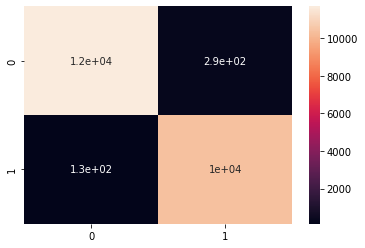

In [379]:
import seaborn as sns
sns.heatmap(cnf_matrix, annot=True)

In [375]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
precision_train = precision_score(y_train, y_hat_train)
precision_test = precision_score(y_test, y_hat_test)
recall_train = recall_score(y_train, y_hat_train)
recall_test = recall_score(y_test, y_hat_test)
accuracy_train = accuracy_score(y_train, y_hat_train)
accuracy_test = accuracy_score(y_test, y_hat_test)
f1_train = f1_score(y_train, y_hat_train)
f1_test = f1_score(y_test, y_hat_test)

In [376]:
print('precision_train is', precision_train)
print('precision_test is', precision_test)
print('recall_train is', recall_train)
print('recall_test is', recall_test)
print('accuracy_train is', accuracy_train)
print('accuracy_test is', accuracy_test)
print('f1_train is', f1_train)
print('f1_test is', f1_test)

precision_train is 0.9661694725476867
precision_test is 0.9727986539540101
recall_train is 0.9922789436937862
recall_test is 0.9880375961264597
accuracy_train is 0.9803238758539323
accuracy_test is 0.9814855925054389
f1_train is 0.9790501661398817
f1_test is 0.9803589091422921


<AxesSubplot:>

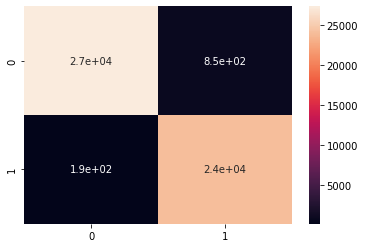

In [377]:
import seaborn as sns
sns.heatmap(cnf_matrix, annot=True)

In [381]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 500, bootstrap = True,
                               max_features = 'sqrt', max_depth = 90, min_samples_leaf = 1, min_samples_split = 5) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
y_tain_pred = clf.fit(X_train_scaled, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test_scaled)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

/opt/anaconda3/envs/Churn_data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys



ACCURACY OF THE MODEL:  0.9974692536518226


In [383]:
train_rf_predictions = clf.predict(X_train_scaled)
train_rf_probs = clf.predict_proba(X_train_scaled)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = clf.predict(X_test_scaled)
rf_probs = clf.predict_proba(X_test_scaled)[:, 1]

In [384]:
final_predict_prob = pd.DataFrame(rf_probs, index =X_test_scaled.index)

In [385]:
final_predict_pred = pd.DataFrame(rf_predictions, index =X_test_scaled.index)

Recall Baseline: 1.0 Test: 0.99 Train: 1.0
Precision Baseline: 0.47 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


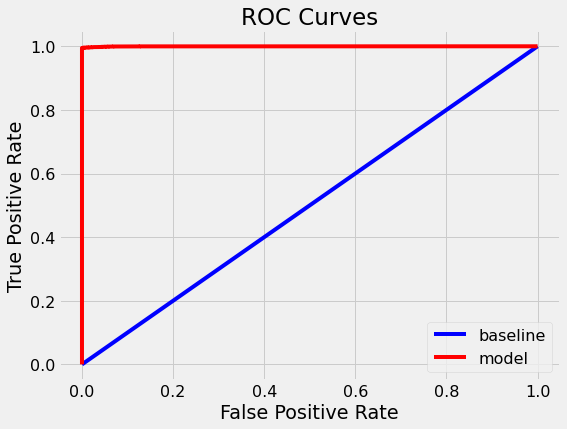

In [407]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)



In [392]:
cnf_matrix = confusion_matrix(y_train, train_rf_predictions)

<AxesSubplot:>

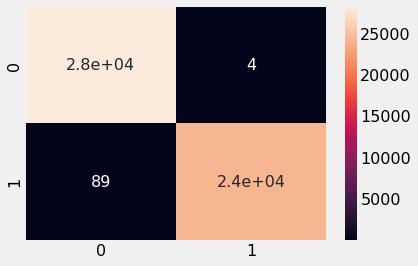

In [393]:
import seaborn as sns
sns.heatmap(cnf_matrix, annot=True)

In [394]:
clf.feature_importances_

array([5.42462891e-03, 1.88857808e-03, 1.78777824e-02, 5.86469534e-02,
       7.10100159e-02, 2.26071403e-04, 6.86671119e-02, 8.19916937e-03,
       5.03507953e-03, 5.09606727e-03, 7.85412096e-02, 7.79534352e-02,
       5.25417191e-05, 1.33781260e-02, 1.93566597e-03, 3.38461916e-03,
       6.08024047e-02, 4.85987412e-02, 3.20788123e-02, 1.45657500e-02,
       1.87014422e-02, 3.48925599e-05, 3.38939501e-05, 4.26518233e-02,
       6.90343931e-05, 6.65900490e-04, 6.67251189e-05, 2.09330038e-09,
       2.03640974e-02, 2.46384906e-05, 3.58638294e-02, 1.42657713e-02,
       5.63362229e-06, 1.81757660e-05, 1.56075891e-01, 1.11576586e-01,
       4.59315914e-03, 1.51017104e-02, 1.95699249e-04, 3.15964575e-04,
       3.59169193e-04, 2.73893015e-04, 2.63869871e-04, 1.19415366e-04,
       1.07244524e-04, 8.51380517e-05, 1.43891326e-04, 1.01665769e-04,
       5.85178519e-05, 6.85004936e-05, 1.04453288e-04, 2.48366437e-03,
       1.27053566e-03, 2.35954333e-04, 9.08564534e-05, 8.87553539e-05,
      

In [400]:
feature_importances = pd.DataFrame(clf.feature_importances_, index =X_train_scaled.columns,  columns=['importance']).sort_values\
('importance', ascending=False)

In [404]:
feature_importances['index'] = feature_importances.index

In [410]:
feature_importances.to_csv('feature_importances.csv')

<BarContainer object of 60 artists>

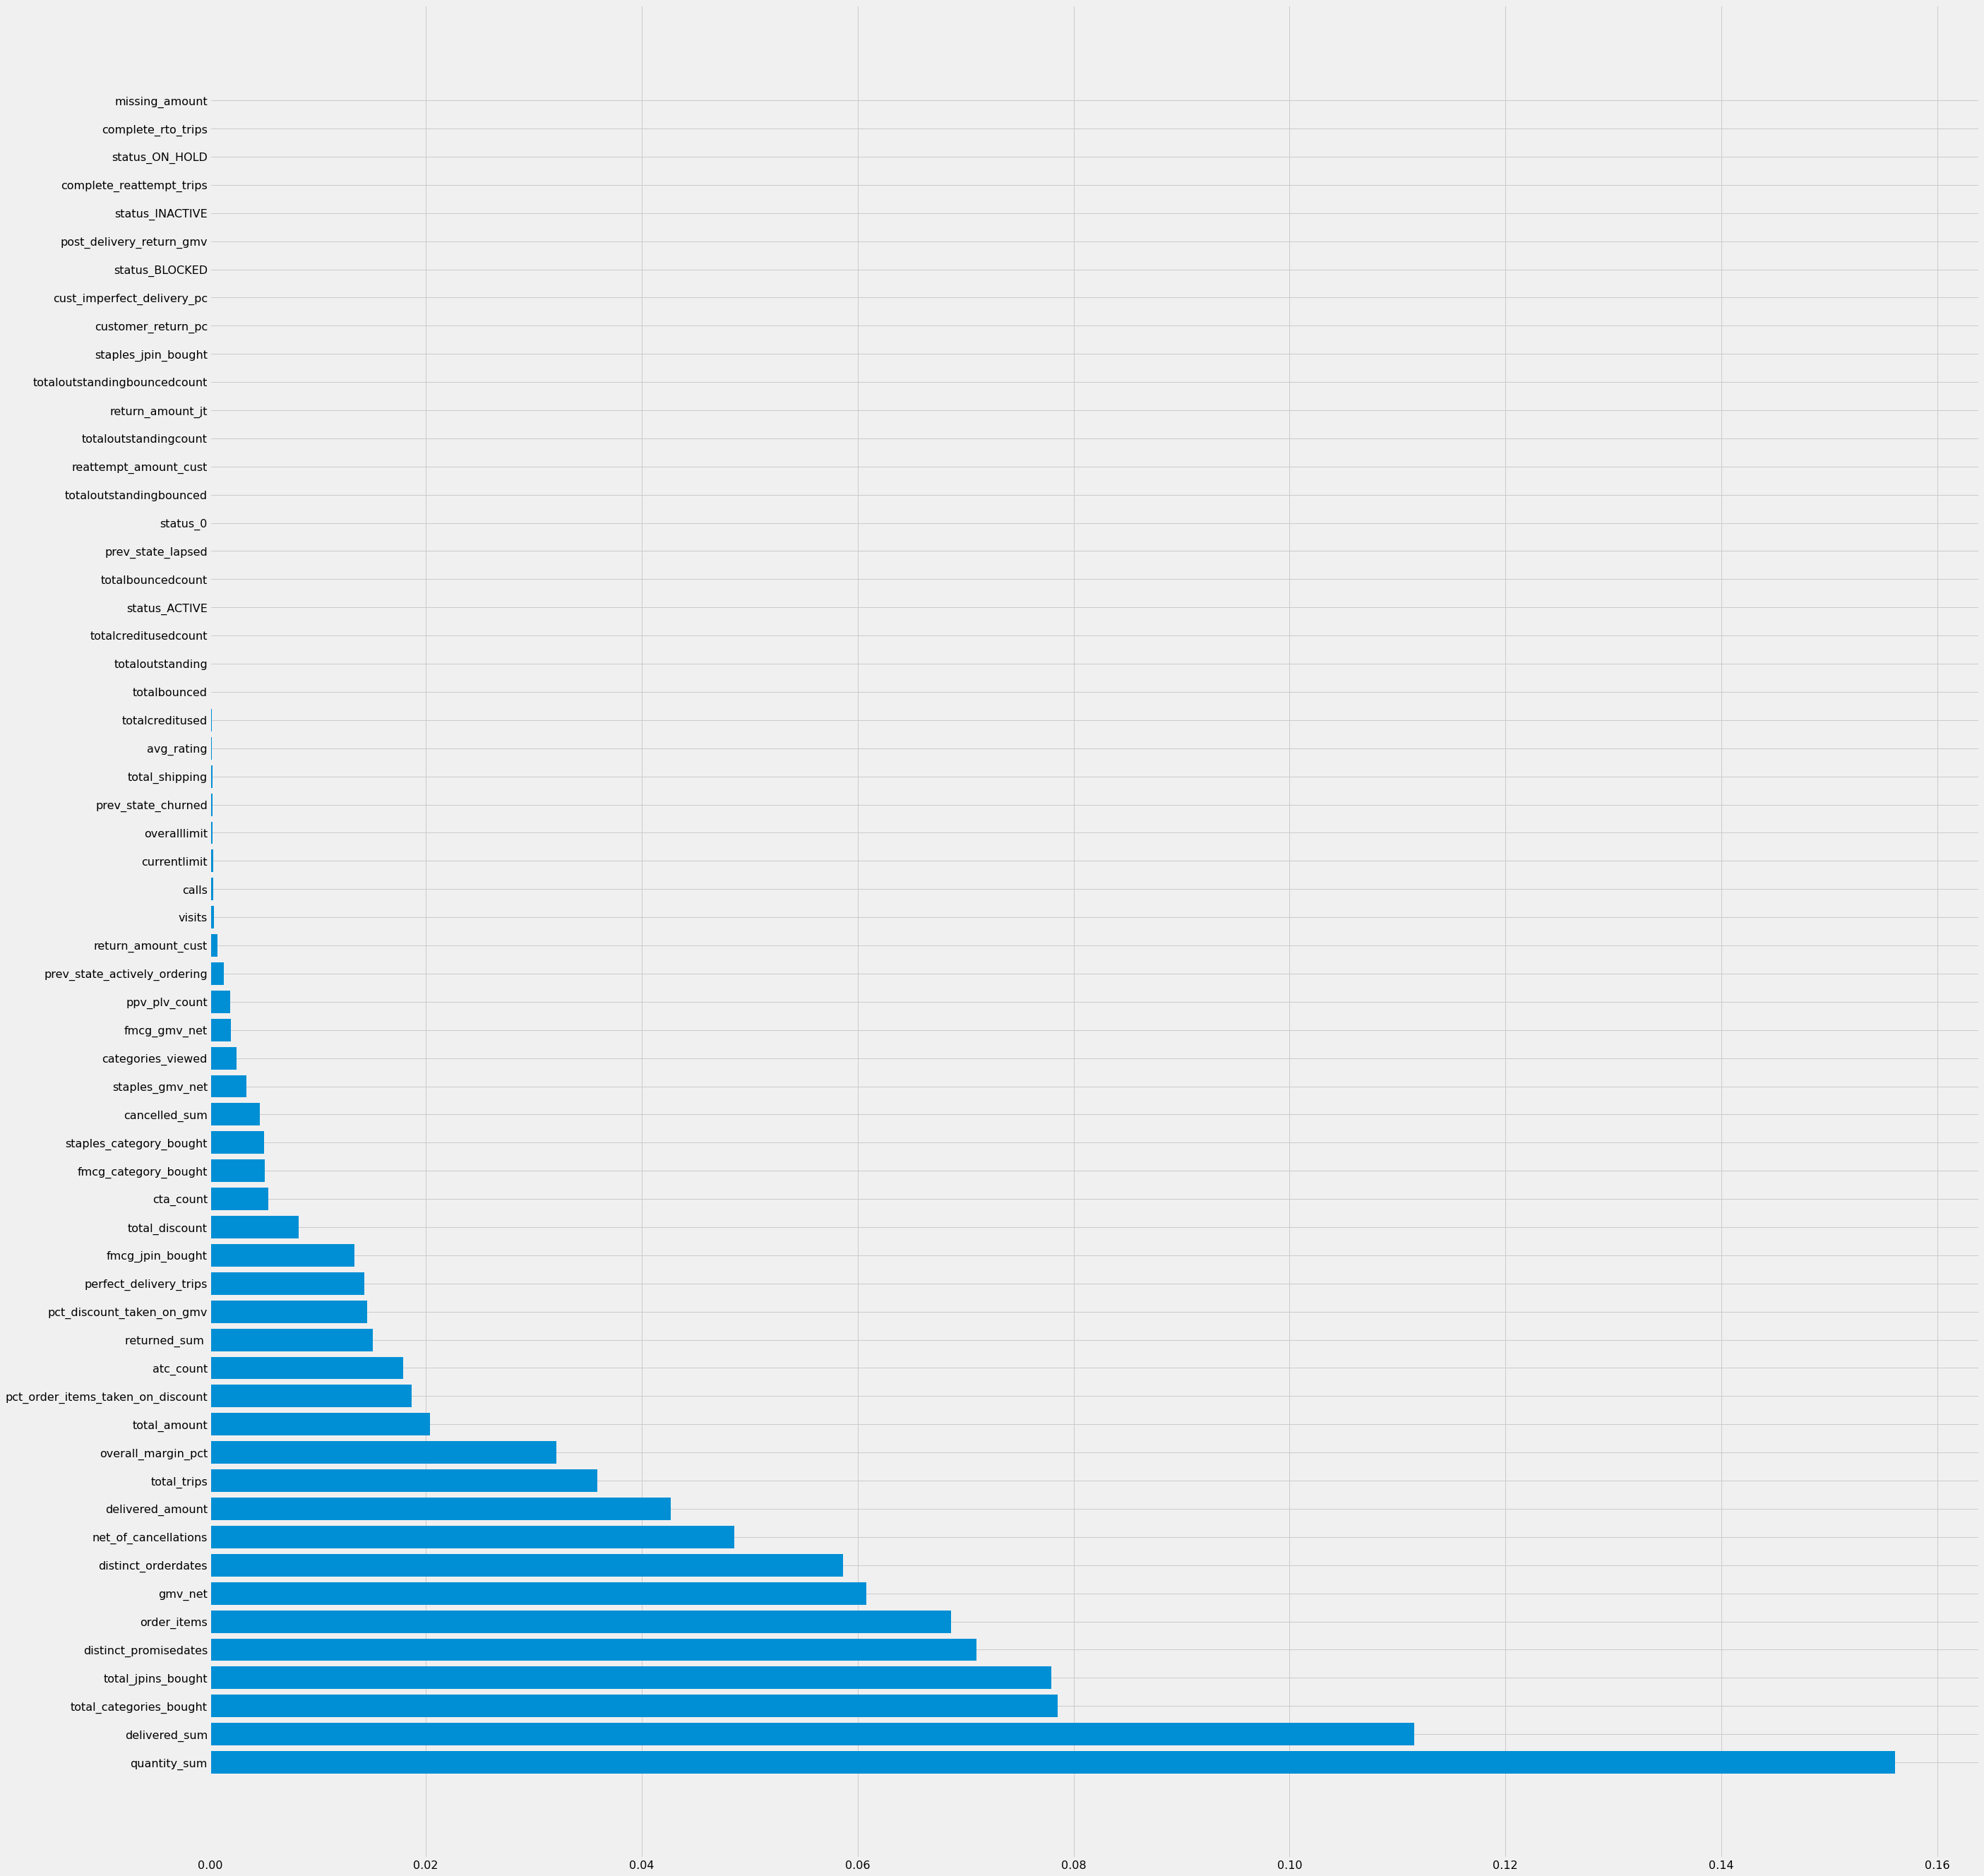

In [406]:
plt.figure(figsize=(40,45))

plt.barh(feature_importances['index'],feature_importances['importance'])


In [411]:
final_df_features

,churn_ind,cta_count,ppv_plv_count,atc_count,distinct_orderdates,distinct_promisedates,total_shipping,order_items,total_discount,staples_category_bought,...,totalcreditusedcount,categories_viewed,prev_state_actively_ordering,prev_state_churned,prev_state_lapsed,status_0,status_ACTIVE,status_BLOCKED,status_INACTIVE,status_ON_HOLD
0,0,189.0,418.0,54.0,26.0,33.0,907.59972,616.0,565.775599,9.0,...,19.0,21.0,1,0,0,0,0,0,0,1
1,0,416.0,943.0,198.0,8.0,11.0,106.72992,96.0,61.689879,7.0,...,0.0,24.0,1,0,0,0,0,1,0,0
2,0,451.0,632.0,60.0,28.0,36.0,1033.89671,1110.0,1946.343262,9.0,...,15.0,23.0,1,0,0,0,0,0,0,1
3,0,1842.0,1765.0,214.0,27.0,28.0,145.12740,92.0,69.420539,7.0,...,56.0,25.0,1,0,0,0,1,0,0,0
4,0,599.0,634.0,37.0,9.0,12.0,400.01796,223.0,308.950297,8.0,...,22.0,23.0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75069,1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0,1,0,0,1,0,0,0
75070,1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0,1,0,1,0,0,0,0
75071,1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0,1,0,1,0,0,0,0
75072,1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0,1,0,1,0,0,0,0


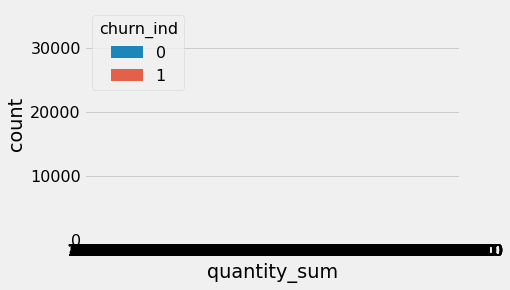

In [413]:
sns.countplot(x='quantity_sum', hue='churn_ind', data=final_df_features);

In [414]:
mega_meta_app_orders_dsat_call_visits_cred_cat_cnt.to_csv('final_features.csv')

In [417]:
mega_meta_app_orders_dsat_call_visits_cred_cat_cnt.columns

Index(['businessid', 'current_state', 'prev_state', 'churn_ind', 'cta_count',
       'ppv_plv_count', 'atc_count', 'distinct_orderdates',
       'distinct_promisedates', 'total_shipping', 'order_items',
       'total_discount', 'staples_category_bought', 'fmcg_category_bought',
       'total_categories_bought', 'total_jpins_bought', 'staples_jpin_bought',
       'fmcg_jpin_bought', 'fmcg_gmv_net', 'staples_gmv_net', 'gmv_net',
       'net_of_cancellations', 'overall_margin_pct',
       'pct_discount_taken_on_gmv', 'pct_order_items_taken_on_discount',
       'customer_return_pc', 'cust_imperfect_delivery_pc', 'delivered_amount',
       'reattempt_amount_cust', 'return_amount_cust', 'return_amount_jt',
       'missing_amount', 'total_amount', 'post_delivery_return_gmv',
       'total_trips', 'perfect_delivery_trips', 'complete_rto_trips',
       'complete_reattempt_trips', 'quantity_sum', 'delivered_sum',
       'cancelled_sum', 'returned_sum ', 'avg_rating', 'calls', 'visits',
       'c

In [443]:
import math 

In [450]:
def hist(feature):
    group_df = mega_meta_app_orders_dsat_call_visits_cred_cat_cnt.groupby([feature, 'churn_ind']).size().reset_index()
    group_df = group_df.rename(columns={0: 'Count'})
    bin_width = 20
    nbins = math.ceil((mega_meta_app_orders_dsat_call_visits_cred_cat_cnt[feature].max() - mega_meta_app_orders_dsat_call_visits_cred_cat_cnt[feature].min()) / bin_width)
    fig = px.histogram(group_df, x=feature, y='Count', color='churn_ind', marginal='box', title=f'Churn frequency to {feature} distribution', color_discrete_sequence=["green", "red"],nbins=nbins)
    fig.show()

In [451]:
import plotly.express as px #for visualization
import matplotlib.pyplot as plt #for visualization

In [452]:
hist('quantity_sum')